# Background

a specific idea that comes to mind:
What if we cast active learning as a semantic reranking problem? (relevant: Cohere is SOTA in reranking, e.g. above OpenAI and Anthropic)
Specifically, the step where you sample from an acquisition function and choose the next input to run can be cast as:
Consider your entire domain of possible experiments or a very high-recall subset of it in some discretized form, cast as a set of documents (i.e. JSON of inputs and predicted outputs from some forward predictive model)
Rerank the next possible experiments vs a query (e.g., the latest experiment(s) and result(s))
Then benchmark actual performance of:
vanilla reranker
finetuned reranker (e.g., showing positive examples from some classic ML algo, to distill that capability into the semantic reranker)
classic ML algo
The high level loop looks basically the same as the plan here. The advantages are that:
reranking is kind of an unusual way to do this but it is suuuuper cheap cost and latency wise, so if it works then that is a very relevant result. And like LLMs, if it is at least as good as classical, it means it is very generalizable since you don't need to worry about featurization since it's all natural language
finetuning is a strong moat since most people do not know how to do it effectively (and obv here is somewhere I can help with some cohere-informed pro tips)
I can probably find a way to get some cohere credits to cover the cost of production-level inference rate limits
11:20
^^^ 
@Hongchen Wang
 wdyt of this? It is probably doable ~immediately on your membrane project if there aren't any blockers
11:21
(it's basically the same as the plan for using o1, but trying something a bit unusual via trying a reranking setup vs a pure generative setup, which means the input space of candidate next-experiments must be discretized, but that's fine since we were planning that anyway)

finetuning is basically like:
given many sets of {query, document, correct_score}
train the model to predict the correct score
12:32
Although the reranking is generally trained to do stuff like question-answering, like if you query "what is the capital of US" over all of wikipedia, you should get the pages for DC and related pages





12:32
but by manipulating the pairings and the correct score, you can finetune the reranker to emit scores based on whatever you like, while retaining it's underlying semantic reasoning that has been pretrained into it
12:34
so there is probably a cool setup where we do something like:
convert experiment params and results into a markdown "report" (could use any LLM for this)
Summarize the experiments tried so far into a summary of findings plus a question, like "ok so these reagents didn't do so well and I think I should vary X next... what next experiment should I try?"
Then you rerank over the candidate possible markdown docs (which are experiments you could run, perhaps also with their predicted results generated via an LLM in markdown)
12:35
it's kinda of a crazy reframe of active learning into "what if everything is a short wiki style markdown document, and we are actually just doing ranking over real empirical documents and hypothetical future documents"
12:35
and the finetune data can just come from your past experiments where you know the results, translated into these markdown docs

try default rerank. Query should be optimizing for something, have previous observations included and remove from relevent passages.  Relevent passages should have all points translated to natrual language. 

Clean dataset, remove useless features

Try rerank on a toy problem first

Benchmark with a general LLM as an active learning

liberally sharing what you are using as queries and strings


# Initialize

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import logging
import time 
import yaml
import random
import cohere
import seaborn as sns
import glob
import re
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

from openai import OpenAI
openrouter_api = "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"
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=openrouter_api,
)

cohere_apiKey = 't4l3ez37771ElFmZXIBquPSmwwHd5jKw5NGjHgP4'
co = cohere.ClientV2(cohere_apiKey)


# Load datasets
loading my experimental data

In [10]:
df = pd.read_csv('propertydata20240927tillbatch37nov21.csv')
df

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,Creep Strain,Plateau Slope,Densification Slope,Changepoint,Fit,Average Standard Deviation
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,NaN,40.371877,990.455813,0.728571,True,53.797772
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,NaN,48.653420,931.396721,0.703094,True,53.797772
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,NaN,48.443704,977.255772,0.683290,True,53.797772
3,Auto_noheating_10wt_3_1_4,True,False,10.00,3,1,4,106.0000,134.939046,88.742717,NaN,795.632583,-69.850029,0.788129,False,53.797772
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,NaN,43.708133,892.534617,0.664271,True,52.829720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Auto_heating_15_36_1_3,True,True,15.00,36,1,3,115.9764,117.304863,10.950087,0.028252,78.602285,1087.690566,0.689427,True,56.663193
239,Auto_heating_15_36_1_4,True,True,15.00,36,1,4,117.7290,121.511233,11.210320,0.034304,92.193790,956.935936,0.665967,False,56.663193
240,Auto_heating_17_36_1_1,True,True,17.00,36,1,1,127.0254,176.661609,14.252450,0.043991,73.241317,1040.322244,0.565335,True,53.182789
241,Auto_heating_17_36_1_2,True,True,17.00,36,1,2,126.2634,178.138828,13.452987,0.046067,85.156251,953.551303,0.541922,True,53.182789


In [11]:
df_parameters = pd.read_csv('all_data_parameters_2024_11_26.csv')
df_parameters

,Auto,Heating,Concentration,Batch,Sample,Mixing Height and Lift Adjusted,Heated Container,Heated Block,Heating Block Temperature,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,True,False,10.00,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
1,True,False,11.63,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
2,True,False,14.43,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.011184
3,True,False,17.00,3,1,1,0,0,25,False,4,0.0,1,0,2024-02-12,64,0,0,0.013384
4,True,False,10.00,4,1,1,0,0,25,True,1,0.0,1,0,2024-02-23,61,0,0,0.156273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,False,False,15.00,35,1,1,0,0,25,False,0,0.0,1,1,2024-11-18,50,0,0,0.190041
75,False,False,17.00,35,1,1,0,0,25,False,0,0.0,1,1,2024-11-18,50,0,0,0.139232
76,True,True,15.00,36,1,1,0,1,80,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
77,True,True,17.00,36,1,1,0,1,80,False,2,0.0,1,1,2024-11-20,58,0,0,0.047234


In [12]:
# merge the two dataframes on Auto, Heating, Concentration, Batch, Sample
data = pd.merge(df, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# only keep Fit = True
#data = data[data['Fit'] == True]
# heating
# data = data[data['Heating'] == False]
# Coupon-to-Bath Wait Time (min)
# data = data[data['Coupon-to-Bath Wait Time (min)'] == 0]
#data = data[data['Auto'] == True]
#only show date after 2024-10-16
#data = data[data['Date'] > '2024-09-20']
#data = data[data['Relative Humidity'] > 49]
# only take batch 31, 33, 34, 35
#data = data[data['Batch'].isin([31, 33, 34, 35, 36])]

data

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,...,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
3,Auto_noheating_10wt_3_1_4,True,False,10.00,3,1,4,106.0000,134.939046,88.742717,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Auto_heating_15_36_1_3,True,True,15.00,36,1,3,115.9764,117.304863,10.950087,...,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
239,Auto_heating_15_36_1_4,True,True,15.00,36,1,4,117.7290,121.511233,11.210320,...,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
240,Auto_heating_17_36_1_1,True,True,17.00,36,1,1,127.0254,176.661609,14.252450,...,False,2,0.0,1,1,2024-11-20,58,0,0,0.047234
241,Auto_heating_17_36_1_2,True,True,17.00,36,1,2,126.2634,178.138828,13.452987,...,False,2,0.0,1,1,2024-11-20,58,0,0,0.047234


In [13]:
# Group by the specified columns and calculate mean and std for the required properties
data_grouped = data.groupby(['Auto', 'Heating', 'Concentration', 'Batch', 'Sample']).agg({
    'Elastic Modulus': ['mean', 'std'],
    'Yield Strength': ['mean', 'std'],
    'Creep Strain': ['mean', 'std'],
    'Plateau Slope': ['mean', 'std'],
    'Densification Slope': ['mean', 'std'],
    'Changepoint': ['mean', 'std'],
    'Average Standard Deviation': ['mean', 'std'],
    'Coefficient of Variation': ['mean', 'std']
})

# Flatten MultiIndex columns after aggregation
data_grouped.columns = ['_'.join(col).strip() for col in data_grouped.columns.values]
data_grouped = data_grouped.reset_index()

# Merge the grouped data with df_parameters
data_grouped = pd.merge(data_grouped, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# shuffle
#data_grouped = data_grouped.sample(frac=1, random_state=42).reset_index(drop=True)
data_grouped


,Auto,Heating,Concentration,Batch,Sample,Elastic Modulus_mean,Elastic Modulus_std,Yield Strength_mean,Yield Strength_std,Creep Strain_mean,...,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,False,False,10.0,17,1,81.740856,1.742273,38.116387,2.888234,0.013263,...,False,0,0.0,1,1,2024-09-06,84,0,0,0.152649
1,False,False,10.0,17,2,71.688942,14.738893,34.488430,15.511729,0.012664,...,False,0,0.0,1,1,2024-09-06,84,0,0,0.150449
2,False,False,10.0,31,1,66.301515,15.957098,26.905106,30.310886,0.014821,...,False,0,0.0,1,1,2024-11-13,48,0,0,0.020273
3,False,False,10.0,35,1,79.491623,16.744100,10.078773,1.835607,0.013063,...,False,0,0.0,1,1,2024-11-18,50,0,0,0.023204
4,False,False,12.0,31,1,109.607330,18.699564,51.207371,3.225834,0.020446,...,False,0,0.0,1,1,2024-11-13,48,0,0,0.169626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,True,True,13.0,9,1,65.487194,7.960978,16.342433,6.287249,NaN,...,True,1,0.0,1,0,2024-04-04,96,0,0,0.120735
69,True,True,15.0,36,1,110.694821,11.720760,10.352956,0.957176,0.030112,...,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
70,True,True,17.0,8,1,172.073230,7.440453,14.187168,0.539781,NaN,...,False,1,0.0,1,0,2024-03-28,53,0,0,0.008657
71,True,True,17.0,10,1,270.693234,20.802095,24.662272,12.804075,NaN,...,False,1,0.0,1,0,2024-04-24,96,0,0,0.144774


# Random

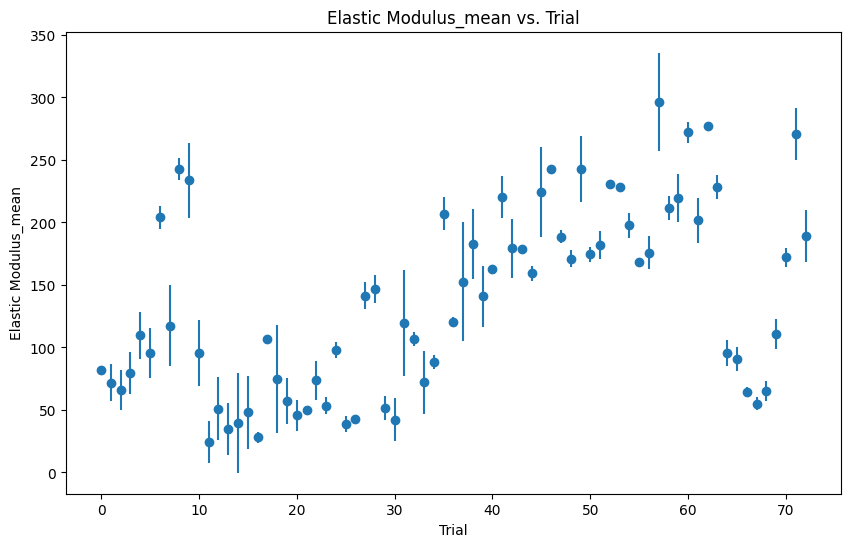

In [14]:
# shuffle the data 
#data_grouped = data_grouped.sample(frac=1, random_state=42).reset_index(drop=True)
# plot Elastic Modulus_mean vs. a time axis, also add the error bars
plt.figure(figsize=(10, 6))
plt.errorbar(data_grouped.index, data_grouped['Elastic Modulus_mean'], yerr=data_grouped['Elastic Modulus_std'], fmt='o')
plt.xlabel('Trial')
plt.ylabel('Elastic Modulus_mean')
plt.title('Elastic Modulus_mean vs. Trial')
plt.show()


# Traditional ML

d:\Anaconda\envs\py39\lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
2025-03-31 14:39:57,000 - INFO - Iteration 1: Alpha=22.00
d:\Anaconda\envs\py39\lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
2025-03-31 14:39:57,020 - INFO - Iteration 1: Selected Index=36, MSE=22424.954247
2025-03-31 14:39:57,021 - INFO - Iteration 2: Alpha=22.00
d:\Anaconda\envs\py39\lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the speci

Stopping early at iteration 10 - Max modulus found.
Saved trajectory data to al_trajectory_data/gpr_experiment_trajectory_alpha22_seed42.csv


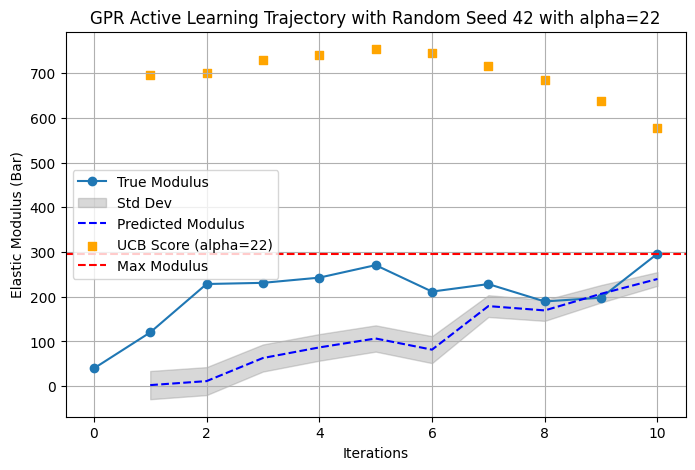

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define the Active Learning UCB class
class ActiveLearningUCB:
    def __init__(self, kernel=None, alpha=1.0, random_state=42):
        self.alpha = alpha
        self.kernel = kernel if kernel else C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10, random_state=random_state)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def ucb_acquisition(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        return mean + self.alpha * std, mean, std

    def select_next_point(self, X_candidates):
        ucb_scores, mean, std = self.ucb_acquisition(X_candidates)
        return np.argmax(ucb_scores), ucb_scores, mean, std


# Preprocessing
def preprocess_data(data):
    X = data.drop([
        'Elastic Modulus_mean', 'Elastic Modulus_std', 'Yield Strength_mean',
        'Yield Strength_std', 'Creep Strain_mean', 'Creep Strain_std',
        'Plateau Slope_mean', 'Plateau Slope_std', 'Densification Slope_mean',
        'Densification Slope_std', 'Changepoint_mean', 'Changepoint_std', 'Date',
        'Average Standard Deviation_mean', 'Average Standard Deviation_std',
        'Coefficient of Variation_mean', 'Coefficient of Variation_std',
        'Coefficient of Variation', 'Batch', 'Sample', 'Mixing Height and Lift Adjusted', 'Heated Container', 'Heated Block',
        'Cast Position Adjusted', 'Lifting Delay'
    ], axis=1)
    # replacce True with 1 and False with 0
    X = X * 1
    y = data['Elastic Modulus_mean']
    yerr = data['Elastic Modulus_std']
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    return X, y, yerr, X_normalized, scaler


# Active Learning Loop
def run_active_learning(data, initial_train_point = 1, alpha = 0.1, random_seed=42):
    # Preprocess data
    X, y, yerr, X_normalized, scaler = preprocess_data(data)
    # Initial training data
    random.seed(random_seed)
    # Select initial training data
    initial_idx = random.choice(list(range(len(X))))  # Ensure it's an integer position
    X_train = X_normalized[[initial_idx], :]
    y_train = np.array([[y.iloc[initial_idx]]])  # Use iloc to access by position
    #X_train_normalized = scaler.transform(X_train)

    # Initialize Active Learning Model
    #al_model = ActiveLearningUCB(alpha=alpha_initial)
    al_model = ActiveLearningUCB(alpha=alpha, random_state=random_seed)
    al_model.update_model(X_train, y_train.ravel())

    # Initialize tracking variables
    selected_indices = [initial_idx]
    iteration_indices = [0]  # Start at iteration 0 for first observation
    selected_modulus = [y.iloc[initial_idx]]
    mse_per_iteration = []
    ucb_scores_list = []
    mean_predictions = []
    std_predictions = []
    max_modulus = y.max()

    # Store trajectory data for saving
    trajectory_data = [{
        "Iteration": 0,
        "Experiment Index": initial_idx,
        "Observed Elastic Modulus": y.iloc[initial_idx],
        "UCB Score": None,  # No UCB score for initial selection
        "Mean Prediction": None,
        "Standard Deviation": None,
        "Max Modulus in Dataset": max_modulus,
        "Stopping Reason": "Initial selection"
    }]

    for iteration in range(len(X) - initial_train_point):
        # Dynamic Alpha Adjustment
        #al_model.alpha = max(0.1, alpha_initial / (1 + iteration * alpha_decay))
        al_model.alpha = alpha
        logging.info(f"Iteration {iteration + 1}: Alpha={al_model.alpha:.2f}")

        # Filter out already selected indices
        available_indices = [i for i in range(len(X)) if i not in selected_indices]
        if not available_indices:
            print("No more available candidates.")
            break
        X_candidates_filtered = X_normalized[available_indices, :]

        # Select next point
        selected_idx_local, ucb_scores, mean, std = al_model.select_next_point(X_candidates_filtered)
        selected_idx = available_indices[selected_idx_local]

        # Store UCB, mean, and std values for visualization
        ucb_scores_list.append(ucb_scores[selected_idx_local])
        mean_predictions.append(mean[selected_idx_local])
        std_predictions.append(std[selected_idx_local])

        # Save selected point information
        iteration_indices.append(iteration + 1)
        selected_indices.append(selected_idx)
        selected_modulus.append(y.iloc[selected_idx])
        
        # Update training data
        X_new = X_normalized[[selected_idx], :]
        y_new = np.array([[y.iloc[selected_idx]]])


        # Append new data while maintaining 2D shape
        X_train = np.vstack([X_train, X_new])
        y_train = np.vstack([y_train, y_new])

        al_model.update_model(X_train, y_train.ravel())

        # Performance Validation
        predictions = al_model.model.predict(X_normalized)
        mse = mean_squared_error(y, predictions)
        mse_per_iteration.append(mse)
        logging.info(f"Iteration {iteration + 1}: Selected Index={selected_idx}, MSE={mse:.6f}")
        # Save trajectory data
        trajectory_data.append({
            "Iteration": iteration + 1,
            "Experiment Index": selected_idx,
            "Observed Elastic Modulus": y.iloc[selected_idx],
            "UCB Score": ucb_scores[selected_idx_local],
            "Mean Prediction": mean[selected_idx_local],
            "Standard Deviation": std[selected_idx_local],
            "Max Modulus in Dataset": max_modulus,
            "Stopping Reason": "Max modulus reached" if y.iloc[selected_idx] >= max_modulus else "Continuing"
        })

        best_modulus = max(selected_modulus)
        # Early Stopping Condition: If no improvement, stop
        if best_modulus >= max_modulus:
            print(f"Stopping early at iteration {iteration+1} - Max modulus found.")
            break  
    

    # Save trajectory data to CSV
    trajectory_df = pd.DataFrame(trajectory_data)
    filename = f"al_trajectory_data/gpr_experiment_trajectory_alpha{alpha}_seed{random_seed}.csv"
    trajectory_df.to_csv(filename, index=False)
    print(f"Saved trajectory data to {filename}")


    # Generate plots
    plt.figure(figsize=(8, 5))
    plt.plot(iteration_indices, selected_modulus, marker='o', label="True Modulus", linestyle='-')
    plt.fill_between(iteration_indices[1:], 
                     np.array(mean_predictions) - np.array(std_predictions), 
                     np.array(mean_predictions) + np.array(std_predictions), 
                     color="gray", alpha=0.3, label="Std Dev")
    plt.plot(iteration_indices[1:], mean_predictions, linestyle='--', color="blue", label="Predicted Modulus")
    plt.scatter(iteration_indices[1:], ucb_scores_list, marker='s', color="orange", label=f"UCB Score (alpha={alpha})")
    plt.axhline(y=max_modulus, color='r', linestyle='--', label='Max Modulus')
    plt.xlabel("Iterations")
    plt.ylabel("Elastic Modulus (Bar)")
    plt.title(f"GPR Active Learning Trajectory with Random Seed {random_seed} with alpha={alpha}")
    plt.legend()
    plt.grid()
    plt.show()


run_active_learning(data_grouped, initial_train_point=1, alpha = 22, random_seed=42)


# For LLM-AL

In [32]:
df = pd.read_csv('all_data_parameters_2024_11_26_forAL.csv')
df.drop(columns=['Batch', 'Sample', 'Date', 'Report', 'Formatted_Parameters'], inplace=True)
# insert a index column
df.insert(0, 'Index', range(1, 1 + len(df)))

# Systematically generate a column with "column_name: value" format for each row
def generate_formatted_column(row):
    return '; '.join([f"{col}: {row[col]}" for col in row.index])

# Apply this function to each row to create a new column
df['Formatted_Parameters'] = df.apply(generate_formatted_column, axis=1)

print(df['Formatted_Parameters'][0])

Index: 1; Auto: True; Heating: False; Concentration: 10.0; Heating Block Temperature: 25; Mixed: True; Rest Time (days): 4; Coupon-to-Bath Wait Time (min): 0.0; Relative Humidity: 64; Nitrogen (Side from drop): 0; Nitrogen (After blade): 0


In [33]:
def Generate_report(Formatted_Parameters, Model = "anthropic/claude-3.7-sonnet", Temperature = 0.0, sleep = 0.5):
    response = client.chat.completions.create(
      model= Model,
      messages=[{"role": "system", "content": 'Here I have a set of structured experimental parameters for my automated membrane synthesis via non-solvent-induced phase seperation (NIPS) using my robotic system. Index is the index number of the experiment. Auto means that whether the synthesis is automated or manual. Heating means whether the solution mixing process has heating involved. Concentration means the polymer (polysulfone) concentration in the solution (solvent is PolarClean). Heating block temperature means the temperature of the heating block during the mixing process. Mixed means whether the solution is mixed (diluted) by the robot or premixed manually. Rest time means the number days the solution is rested in a sample vial after mixing before blade casting. Coupon-to-Bath Wait Time (min) means how long the sample is waited in minutes after blade casting before immersion in the NIPS bath. Relative Humidity means the RH% of the day the sample is synthesized into membrane. Nitrogen (Side from drop) means whether the polymer solution undergoes a laminar dry nitrogen blow to remove humidity since it is drop-cast on to the coupon before blade casting until it is immersed into the NIPS bath. Nitrogen (After blade) means whether the polymer solution undergoes a laminar dry nitrgen blow after it is blade-cast until it is immersed into the NIPS bath. Can you translate that into a short experimental report? '},
                {"role": "user", "content": Formatted_Parameters}
                ],
      temperature=Temperature
    )
    time.sleep(sleep)
    return response.choices[0].message.content

In [34]:
reports = []  # Initialize an empty list to store each generated report

for row in df['Formatted_Parameters']:
    report = Generate_report(row)
    reports.append(report)  # Append each generated report to the list

df['Report'] = reports  # Assign the list of reports to the DataFrame


In [35]:
for row in df['Formatted_Parameters']:
    print(row)

Index: 1; Auto: True; Heating: False; Concentration: 10.0; Heating Block Temperature: 25; Mixed: True; Rest Time (days): 4; Coupon-to-Bath Wait Time (min): 0.0; Relative Humidity: 64; Nitrogen (Side from drop): 0; Nitrogen (After blade): 0
Index: 2; Auto: True; Heating: False; Concentration: 11.63; Heating Block Temperature: 25; Mixed: True; Rest Time (days): 4; Coupon-to-Bath Wait Time (min): 0.0; Relative Humidity: 64; Nitrogen (Side from drop): 0; Nitrogen (After blade): 0
Index: 3; Auto: True; Heating: False; Concentration: 14.43; Heating Block Temperature: 25; Mixed: True; Rest Time (days): 4; Coupon-to-Bath Wait Time (min): 0.0; Relative Humidity: 64; Nitrogen (Side from drop): 0; Nitrogen (After blade): 0
Index: 4; Auto: True; Heating: False; Concentration: 17.0; Heating Block Temperature: 25; Mixed: False; Rest Time (days): 4; Coupon-to-Bath Wait Time (min): 0.0; Relative Humidity: 64; Nitrogen (Side from drop): 0; Nitrogen (After blade): 0
Index: 5; Auto: True; Heating: False;

In [36]:
df['Report'][0]

'# Experimental Report: Automated Membrane Synthesis via NIPS\n\n## Experiment Parameters\n- **Experiment ID**: 1\n- **Synthesis Method**: Automated NIPS (Non-solvent-Induced Phase Separation)\n- **Polymer**: Polysulfone at 10.0% concentration\n- **Solvent**: PolarClean\n\n## Procedure\n1. The polymer solution was automatically mixed by the robotic system at room temperature (25°C) without heating.\n2. The mixed solution was allowed to rest in a sample vial for 4 days before processing.\n3. The solution was automatically drop-cast onto the substrate and then blade-cast.\n4. The cast film was immediately immersed in the NIPS bath (0.0 min wait time).\n5. The entire process was conducted at 64% relative humidity.\n6. No nitrogen flow was applied either during the drop-casting or after blade-casting phases.\n\nThis experiment represents a baseline automated membrane synthesis without thermal assistance or humidity control measures.'

In [ ]:
#df.to_csv('all_data_parameters_2024_11_26_forAL.csv', index=False)

In [191]:
df_parameters = pd.read_csv('all_data_parameters_2024_11_26_forAL.csv')
df_parameters

,Index,Auto,Heating,Concentration,Batch,Sample,Date,Coefficient of Variation,Heating Block Temperature,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Formatted_Parameters,Report
0,1,True,False,10.00,3,1,2024-02-12,0.036915,25,True,4,0.0,64,0,0,Index: 1; Auto: True; Heating: False; Concentr...,# Experimental Report: Automated Membrane Synt...
1,2,True,False,11.63,3,1,2024-02-12,0.010549,25,True,4,0.0,64,0,0,Index: 2; Auto: True; Heating: False; Concentr...,# Experimental Report: Automated Membrane Synt...
2,3,True,False,14.43,3,1,2024-02-12,0.011184,25,True,4,0.0,64,0,0,Index: 3; Auto: True; Heating: False; Concentr...,# Experimental Report: Automated Membrane Synt...
3,4,True,False,17.00,3,1,2024-02-12,0.013384,25,False,4,0.0,64,0,0,Index: 4; Auto: True; Heating: False; Concentr...,# Experimental Report: Automated Membrane Synt...
4,5,True,False,10.00,4,1,2024-02-23,0.156273,25,True,1,0.0,61,0,0,Index: 5; Auto: True; Heating: False; Concentr...,# Experimental Report: Automated Membrane Synt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,75,False,False,15.00,35,1,2024-11-18,0.190041,25,False,0,0.0,50,0,0,Index: 75; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...
75,76,False,False,17.00,35,1,2024-11-18,0.139232,25,False,0,0.0,50,0,0,Index: 76; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...
76,77,True,True,15.00,36,1,2024-11-20,0.052464,80,True,2,0.0,58,0,0,Index: 77; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...
77,78,True,True,17.00,36,1,2024-11-20,0.047234,80,False,2,0.0,58,0,0,Index: 78; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...


In [192]:
df = pd.read_csv('propertydata20240927tillbatch37nov21.csv')
df

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,Creep Strain,Plateau Slope,Densification Slope,Changepoint,Fit,Average Standard Deviation
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,NaN,40.371877,990.455813,0.728571,True,53.797772
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,NaN,48.653420,931.396721,0.703094,True,53.797772
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,NaN,48.443704,977.255772,0.683290,True,53.797772
3,Auto_noheating_10wt_3_1_4,True,False,10.00,3,1,4,106.0000,134.939046,88.742717,NaN,795.632583,-69.850029,0.788129,False,53.797772
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,NaN,43.708133,892.534617,0.664271,True,52.829720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Auto_heating_15_36_1_3,True,True,15.00,36,1,3,115.9764,117.304863,10.950087,0.028252,78.602285,1087.690566,0.689427,True,56.663193
239,Auto_heating_15_36_1_4,True,True,15.00,36,1,4,117.7290,121.511233,11.210320,0.034304,92.193790,956.935936,0.665967,False,56.663193
240,Auto_heating_17_36_1_1,True,True,17.00,36,1,1,127.0254,176.661609,14.252450,0.043991,73.241317,1040.322244,0.565335,True,53.182789
241,Auto_heating_17_36_1_2,True,True,17.00,36,1,2,126.2634,178.138828,13.452987,0.046067,85.156251,953.551303,0.541922,True,53.182789


In [194]:
# merge the two dataframes on Auto, Heating, Concentration, Batch, Sample
data = pd.merge(df, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# only keep Fit = True
#data = data[data['Fit'] == True]
# heating
#data = data[data['Heating'] == False]
# Coupon-to-Bath Wait Time (min)
#data = data[data['Coupon-to-Bath Wait Time (min)'] == 0]
# data = data[data['Auto'] == True]
#only show date after 2024-10-16
#data = data[data['Date'] > '2024-09-20']
#data = data[data['Relative Humidity'] > 49]
# only take batch 31, 33, 34, 35
#data = data[data['Batch'].isin([31, 33, 34, 35, 36])]

data

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,...,Coefficient of Variation,Heating Block Temperature,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Formatted_Parameters,Report
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,...,0.036915,25,True,4,0.0,64,0,0,Index: 1; Auto: True; Heating: False; Concentr...,# Experimental Report: Automated Membrane Synt...
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,...,0.036915,25,True,4,0.0,64,0,0,Index: 1; Auto: True; Heating: False; Concentr...,# Experimental Report: Automated Membrane Synt...
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,...,0.036915,25,True,4,0.0,64,0,0,Index: 1; Auto: True; Heating: False; Concentr...,# Experimental Report: Automated Membrane Synt...
3,Auto_noheating_10wt_3_1_4,True,False,10.00,3,1,4,106.0000,134.939046,88.742717,...,0.036915,25,True,4,0.0,64,0,0,Index: 1; Auto: True; Heating: False; Concentr...,# Experimental Report: Automated Membrane Synt...
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,...,0.010549,25,True,4,0.0,64,0,0,Index: 2; Auto: True; Heating: False; Concentr...,# Experimental Report: Automated Membrane Synt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Auto_heating_15_36_1_3,True,True,15.00,36,1,3,115.9764,117.304863,10.950087,...,0.052464,80,True,2,0.0,58,0,0,Index: 77; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...
239,Auto_heating_15_36_1_4,True,True,15.00,36,1,4,117.7290,121.511233,11.210320,...,0.052464,80,True,2,0.0,58,0,0,Index: 77; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...
240,Auto_heating_17_36_1_1,True,True,17.00,36,1,1,127.0254,176.661609,14.252450,...,0.047234,80,False,2,0.0,58,0,0,Index: 78; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...
241,Auto_heating_17_36_1_2,True,True,17.00,36,1,2,126.2634,178.138828,13.452987,...,0.047234,80,False,2,0.0,58,0,0,Index: 78; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...


In [195]:
# Group by the specified columns and calculate mean and std for the required properties
data_grouped = data.groupby(['Auto', 'Heating', 'Concentration', 'Batch', 'Sample']).agg({
    'Elastic Modulus': ['mean', 'std'],
    'Yield Strength': ['mean', 'std'],
    'Creep Strain': ['mean', 'std'],
    'Plateau Slope': ['mean', 'std'],
    'Densification Slope': ['mean', 'std'],
    'Changepoint': ['mean', 'std'],
    'Average Standard Deviation': ['mean', 'std'],
    'Coefficient of Variation': ['mean', 'std']
})

# Flatten MultiIndex columns after aggregation
data_grouped.columns = ['_'.join(col).strip() for col in data_grouped.columns.values]
data_grouped = data_grouped.reset_index()

# Merge the grouped data with df_parameters
data_grouped = pd.merge(data_grouped, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# shuffle
#data_grouped = data_grouped.sample(frac=1, random_state=42).reset_index(drop=True)
data_grouped#.to_csv('all_data_parameters_2024_11_26_forAL_grouped.csv', index=False)


,Auto,Heating,Concentration,Batch,Sample,Elastic Modulus_mean,Elastic Modulus_std,Yield Strength_mean,Yield Strength_std,Creep Strain_mean,...,Coefficient of Variation,Heating Block Temperature,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Formatted_Parameters,Report
0,False,False,10.0,17,1,81.740856,1.742273,38.116387,2.888234,0.013263,...,0.152649,25,False,0,0.0,84,0,0,Index: 35; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...
1,False,False,10.0,17,2,71.688942,14.738893,34.488430,15.511729,0.012664,...,0.150449,25,False,0,0.0,84,0,0,Index: 36; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...
2,False,False,10.0,31,1,66.301515,15.957098,26.905106,30.310886,0.014821,...,0.020273,25,False,0,0.0,48,0,0,Index: 57; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...
3,False,False,10.0,35,1,79.491623,16.744100,10.078773,1.835607,0.013063,...,0.023204,25,False,0,0.0,50,0,0,Index: 73; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...
4,False,False,12.0,31,1,109.607330,18.699564,51.207371,3.225834,0.020446,...,0.169626,25,False,0,0.0,48,0,0,Index: 58; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,True,True,13.0,9,1,65.487194,7.960978,16.342433,6.287249,NaN,...,0.120735,50,True,1,0.0,96,0,0,Index: 18; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...
69,True,True,15.0,36,1,110.694821,11.720760,10.352956,0.957176,0.030112,...,0.052464,80,True,2,0.0,58,0,0,Index: 77; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...
70,True,True,17.0,8,1,172.073230,7.440453,14.187168,0.539781,NaN,...,0.008657,50,False,1,0.0,53,0,0,Index: 17; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...
71,True,True,17.0,10,1,270.693234,20.802095,24.662272,12.804075,NaN,...,0.144774,50,False,1,0.0,96,0,0,Index: 19; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...


In [196]:
# Create another column with "Report" as the first message and 'The measured Elastic Modulus is {Elastic Modulus_mean} with a standard deviation of {Elastic Modulus_std}.' as the second message
data_grouped['Report with output'] = data_grouped.apply(lambda row: f"Report: {row['Report']}" + f" \nThe measured Elastic Modulus is {round(row['Elastic Modulus_mean'], 2)} with a standard deviation of {round(row['Elastic Modulus_std'], 2)}.", axis=1)
print(data_grouped['Report with output'][0])

Report: # Experimental Report: Manual Membrane Synthesis via NIPS

## Experimental Parameters
- **Experiment ID:** 35
- **Synthesis Method:** Manual (non-automated)
- **Polymer Solution:** 10.0% polysulfone in PolarClean solvent
- **Mixing Conditions:** Premixed manually at room temperature (25??C) without heating
- **Solution Preparation:** The polymer solution was used immediately after preparation (0 days rest time)
- **Casting Environment:** High humidity conditions (84% RH)
- **Casting Protocol:** 
  - The polymer solution was drop-cast onto the substrate
  - Blade casting was performed immediately
  - The cast film was immediately immersed in the non-solvent bath (0 minutes wait time)
  - No nitrogen flow was applied at any stage of the process

This experiment represents a baseline manual membrane synthesis process conducted under high humidity conditions without any specialized environmental controls or solution aging. 
The measured Elastic Modulus is 81.74 with a standard devi

In [197]:
data_grouped

,Auto,Heating,Concentration,Batch,Sample,Elastic Modulus_mean,Elastic Modulus_std,Yield Strength_mean,Yield Strength_std,Creep Strain_mean,...,Heating Block Temperature,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Formatted_Parameters,Report,Report with output
0,False,False,10.0,17,1,81.740856,1.742273,38.116387,2.888234,0.013263,...,25,False,0,0.0,84,0,0,Index: 35; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...,Report: # Experimental Report: Manual Membrane...
1,False,False,10.0,17,2,71.688942,14.738893,34.488430,15.511729,0.012664,...,25,False,0,0.0,84,0,0,Index: 36; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...,Report: # Experimental Report: Manual Membrane...
2,False,False,10.0,31,1,66.301515,15.957098,26.905106,30.310886,0.014821,...,25,False,0,0.0,48,0,0,Index: 57; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...,Report: # Experimental Report: Manual Membrane...
3,False,False,10.0,35,1,79.491623,16.744100,10.078773,1.835607,0.013063,...,25,False,0,0.0,50,0,0,Index: 73; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...,Report: # Experimental Report: Manual Membrane...
4,False,False,12.0,31,1,109.607330,18.699564,51.207371,3.225834,0.020446,...,25,False,0,0.0,48,0,0,Index: 58; Auto: False; Heating: False; Concen...,# Experimental Report: Manual Membrane Synthes...,Report: # Experimental Report: Manual Membrane...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,True,True,13.0,9,1,65.487194,7.960978,16.342433,6.287249,NaN,...,50,True,1,0.0,96,0,0,Index: 18; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...,Report: # Experimental Report: Automated Membr...
69,True,True,15.0,36,1,110.694821,11.720760,10.352956,0.957176,0.030112,...,80,True,2,0.0,58,0,0,Index: 77; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...,Report: # Experimental Report: Automated Membr...
70,True,True,17.0,8,1,172.073230,7.440453,14.187168,0.539781,NaN,...,50,False,1,0.0,53,0,0,Index: 17; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...,Report: # Experimental Report: Automated Membr...
71,True,True,17.0,10,1,270.693234,20.802095,24.662272,12.804075,NaN,...,50,False,1,0.0,96,0,0,Index: 19; Auto: True; Heating: True; Concentr...,# Experimental Report: Automated Membrane Synt...,Report: # Experimental Report: Automated Membr...


In [67]:
# Store observations and results
list_of_observations = []  
list_of_modulus = []  

# Copy dataset so original data remains intact
data_copy = data_grouped.copy()  

# Start by randomly selecting an initial experiment
random.seed(42)
initial_idx = random.choice(data_copy.index)
print(f"Initial observation: Experiment {initial_idx}")
list_of_observations.append(data_copy.loc[initial_idx, 'Report with output'])
list_of_modulus.append(data_copy.loc[initial_idx, 'Elastic Modulus_mean'])
data_copy = data_copy.drop(index=initial_idx)

# Iteratively select the next best experiment
for i in range(len(data_copy)):
    # Convert observations into a single string for query
    observations_str = ' '.join(list_of_observations)
    query = f'''Based on the following previous experimental observations, recommend the next experiment that maximizes modulus. Prior experiments were conducted iteratively, with each new trial improving upon the last based on learned trends. Select the next experiment that is expected to provide the most **informative** result while maximizing modulus. \nPrior Observations: {observations_str}'''
    
    # Prepare documents for reranking
    docs = list(data_copy['Report'])

    # Use Cohere's rerank model
    results = co.rerank(model="rerank-v3.5", query=query, documents=docs, top_n=1)
    
    # Extract the best next experiment's index (position-based)
    best_idx = results.results[0].index
    best_experiment = data_copy.iloc[best_idx]  # Retrieve the experiment data

    # Store the newly selected experiment's results
    list_of_observations.append(best_experiment['Report with output'])
    list_of_modulus.append(best_experiment['Elastic Modulus_mean'])

    # Remove the selected experiment from the dataset
    data_copy = data_copy.drop(data_copy.index[best_idx])

    # Print progress
    print(f"Iteration {i+1}: Added new observation (Experiment {best_experiment.name})")
    print(f"Elastic Modulus: {best_experiment['Elastic Modulus_mean']}\n")

    # Optional delay for real-world simulation
    #time.sleep(1)

# Final output
print("Final list of observations:", list_of_observations)
print("Tracked Elastic Modulus values:", list_of_modulus)


Initial observation: Experiment 14


2025-03-19 10:53:34,215 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 1: Added new observation (Experiment 15)
Elastic Modulus: 48.22854697312115



2025-03-19 10:53:34,682 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 2: Added new observation (Experiment 10)
Elastic Modulus: 95.58773206251



2025-03-19 10:53:35,279 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 3: Added new observation (Experiment 16)
Elastic Modulus: 28.085883195904362



2025-03-19 10:53:35,936 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 4: Added new observation (Experiment 11)
Elastic Modulus: 24.71538796928362



2025-03-19 10:53:36,696 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 5: Added new observation (Experiment 41)
Elastic Modulus: 220.5104016857166



2025-03-19 10:53:37,509 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 6: Added new observation (Experiment 26)
Elastic Modulus: 42.736240369816734



2025-03-19 10:53:38,416 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 7: Added new observation (Experiment 18)
Elastic Modulus: 74.82276309333224



2025-03-19 10:53:39,372 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 8: Added new observation (Experiment 1)
Elastic Modulus: 71.68894182884907



2025-03-19 10:53:40,338 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 9: Added new observation (Experiment 45)
Elastic Modulus: 224.5706110108938



2025-03-19 10:53:41,284 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 10: Added new observation (Experiment 23)
Elastic Modulus: 53.46447392343188



2025-03-19 10:53:42,222 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 11: Added new observation (Experiment 52)
Elastic Modulus: 231.07458974395303



2025-03-19 10:53:43,112 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 12: Added new observation (Experiment 54)
Elastic Modulus: 197.84044623035882



2025-03-19 10:53:44,031 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 13: Added new observation (Experiment 43)
Elastic Modulus: 178.97379271834268



2025-03-19 10:53:44,923 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 14: Added new observation (Experiment 66)
Elastic Modulus: 64.29918271351211



2025-03-19 10:53:45,866 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 15: Added new observation (Experiment 24)
Elastic Modulus: 98.05789122606569



2025-03-19 10:53:46,791 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 16: Added new observation (Experiment 42)
Elastic Modulus: 179.2410423946837



2025-03-19 10:53:47,711 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 17: Added new observation (Experiment 12)
Elastic Modulus: 51.16844398555743



2025-03-19 10:53:48,640 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 18: Added new observation (Experiment 0)
Elastic Modulus: 81.74085575257114



2025-03-19 10:53:49,541 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 19: Added new observation (Experiment 48)
Elastic Modulus: 171.00469374345903



2025-03-19 10:53:50,456 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 20: Added new observation (Experiment 39)
Elastic Modulus: 140.76871335709305



2025-03-19 10:53:51,382 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 21: Added new observation (Experiment 35)
Elastic Modulus: 207.09310351510177



2025-03-19 10:54:06,470 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 22: Added new observation (Experiment 49)
Elastic Modulus: 242.91509227554656



2025-03-19 10:54:07,466 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 23: Added new observation (Experiment 4)
Elastic Modulus: 109.60733027971378



2025-03-19 10:54:08,363 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 24: Added new observation (Experiment 46)
Elastic Modulus: 242.41091008794928



2025-03-19 10:54:09,277 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 25: Added new observation (Experiment 2)
Elastic Modulus: 66.30151481091211



2025-03-19 10:54:10,199 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 26: Added new observation (Experiment 40)
Elastic Modulus: 162.77817832797786



2025-03-19 10:54:12,517 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 27: Added new observation (Experiment 29)
Elastic Modulus: 51.50598562924656



2025-03-19 10:54:13,464 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 28: Added new observation (Experiment 6)
Elastic Modulus: 204.17680289774339



2025-03-19 10:54:14,411 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 29: Added new observation (Experiment 28)
Elastic Modulus: 147.00005295683096



2025-03-19 10:54:15,308 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 30: Added new observation (Experiment 13)
Elastic Modulus: 35.102261317001975



2025-03-19 10:54:16,185 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 31: Added new observation (Experiment 47)
Elastic Modulus: 188.55697291016554



2025-03-19 10:54:17,067 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 32: Added new observation (Experiment 3)
Elastic Modulus: 79.49162278991126



2025-03-19 10:54:18,026 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 33: Added new observation (Experiment 34)
Elastic Modulus: 88.47667256854467



2025-03-19 10:54:19,065 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 34: Added new observation (Experiment 50)
Elastic Modulus: 174.66437205644556



2025-03-19 10:54:19,962 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 35: Added new observation (Experiment 58)
Elastic Modulus: 211.50865412415317



2025-03-19 10:54:20,888 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 36: Added new observation (Experiment 59)
Elastic Modulus: 219.61643412334288



2025-03-19 10:54:21,815 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 37: Added new observation (Experiment 21)
Elastic Modulus: 50.104313602035774



2025-03-19 10:54:22,714 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 38: Added new observation (Experiment 5)
Elastic Modulus: 95.3466236160471



2025-03-19 10:54:23,613 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 39: Added new observation (Experiment 56)
Elastic Modulus: 175.8319549576918



2025-03-19 10:54:24,474 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 40: Added new observation (Experiment 30)
Elastic Modulus: 42.124759091300646



2025-03-19 10:54:25,462 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 41: Added new observation (Experiment 44)
Elastic Modulus: 159.30709474405634



2025-03-19 10:54:26,352 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 42: Added new observation (Experiment 8)
Elastic Modulus: 242.7128680778461



2025-03-19 10:54:27,216 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 43: Added new observation (Experiment 68)
Elastic Modulus: 65.48719407925006



2025-03-19 10:54:28,076 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 44: Added new observation (Experiment 64)
Elastic Modulus: 95.81586876001887



2025-03-19 10:54:28,875 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 45: Added new observation (Experiment 20)
Elastic Modulus: 45.87195384392433



2025-03-19 10:54:29,650 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 46: Added new observation (Experiment 53)
Elastic Modulus: 228.31076155204596



2025-03-19 10:54:30,455 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 47: Added new observation (Experiment 67)
Elastic Modulus: 55.10215022969636



2025-03-19 10:54:31,147 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 48: Added new observation (Experiment 62)
Elastic Modulus: 277.3861208337041



2025-03-19 10:54:31,878 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 49: Added new observation (Experiment 36)
Elastic Modulus: 120.16287053478321



2025-03-19 10:54:32,534 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 50: Added new observation (Experiment 55)
Elastic Modulus: 168.33383829683325



2025-03-19 10:54:33,204 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 51: Added new observation (Experiment 31)
Elastic Modulus: 119.79704241922373



2025-03-19 10:54:33,825 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 52: Added new observation (Experiment 19)
Elastic Modulus: 56.88500845389184



2025-03-19 10:54:34,482 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 53: Added new observation (Experiment 37)
Elastic Modulus: 152.72295816440803



2025-03-19 10:54:35,065 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 54: Added new observation (Experiment 65)
Elastic Modulus: 90.99870959544364



2025-03-19 10:54:35,658 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 55: Added new observation (Experiment 22)
Elastic Modulus: 73.67122147772203



2025-03-19 10:54:36,187 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 56: Added new observation (Experiment 51)
Elastic Modulus: 181.925661105008



2025-03-19 10:54:36,679 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 57: Added new observation (Experiment 32)
Elastic Modulus: 106.70108583654164



2025-03-19 10:54:37,144 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 58: Added new observation (Experiment 9)
Elastic Modulus: 233.72437240576676



2025-03-19 10:54:37,640 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 59: Added new observation (Experiment 25)
Elastic Modulus: 39.13465426900338



2025-03-19 10:54:38,100 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 60: Added new observation (Experiment 60)
Elastic Modulus: 272.2240045816517



2025-03-19 10:54:38,520 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 61: Added new observation (Experiment 7)
Elastic Modulus: 117.40631603510326



2025-03-19 10:54:38,903 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 62: Added new observation (Experiment 27)
Elastic Modulus: 141.45379911190125



2025-03-19 10:54:39,339 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 63: Added new observation (Experiment 72)
Elastic Modulus: 189.44122006132594



2025-03-19 10:54:39,683 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 64: Added new observation (Experiment 17)
Elastic Modulus: 106.8193434000782



2025-03-19 10:54:39,954 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 65: Added new observation (Experiment 70)
Elastic Modulus: 172.0732296612731



2025-03-19 10:54:40,272 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 66: Added new observation (Experiment 33)
Elastic Modulus: 72.06868568538891



2025-03-19 10:54:40,496 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 67: Added new observation (Experiment 69)
Elastic Modulus: 110.69482106635698



2025-03-19 10:54:40,750 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 68: Added new observation (Experiment 38)
Elastic Modulus: 182.9546167355371



2025-03-19 10:54:40,957 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 10:54:41,148 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 69: Added new observation (Experiment 57)
Elastic Modulus: 296.35081017123304



2025-03-19 10:54:41,325 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 70: Added new observation (Experiment 63)
Elastic Modulus: 228.4671903908735

Iteration 71: Added new observation (Experiment 71)
Elastic Modulus: 270.69323356331364



2025-03-19 10:54:41,500 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 72: Added new observation (Experiment 61)
Elastic Modulus: 201.80400290446062

Final list of observations: ['Report: # Experimental Report: Automated Membrane Synthesis via NIPS\n\n## Experiment Parameters\n- **Experiment ID**: 12\n- **Synthesis Method**: Automated robotic system\n- **Polymer Solution**: 10.0% polysulfone in PolarClean solvent\n- **Solution Preparation**: \n  - Automatically mixed by robotic system\n  - No heating applied (ambient temperature of 25??C)\n  - Solution rested for 2 days in sample vial before casting\n\n## Casting Conditions\n- **Environmental Conditions**: 56% relative humidity\n- **Casting Process**:\n  - Automated blade casting\n  - Immediate immersion in non-solvent bath (0.0 min wait time)\n  - No nitrogen flow applied during any stage of the process\n\n## Notes\nThe membrane was synthesized using non-solvent-induced phase separation (NIPS) with fully automated solution preparation and casting. The polymer solution was prepared at room tempe

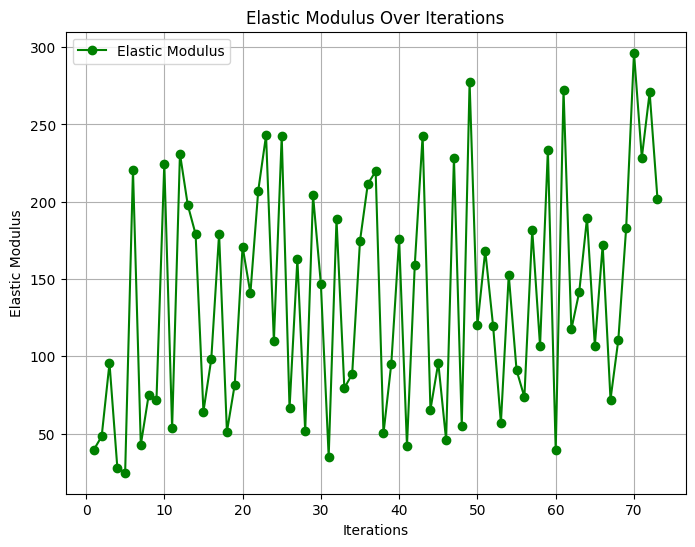

In [68]:
# plot the modulus over iterations
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(list_of_modulus) + 1), list_of_modulus, marker='o', label="Elastic Modulus", color="green")
plt.xlabel("Iterations")
plt.ylabel("Elastic Modulus")
plt.title("Elastic Modulus Over Iterations")
plt.legend()
plt.grid()
plt.show()


In [ ]:
ranges = '\n'.join(df_parameters['Formatted_Parameters'])
response = client.chat.completions.create(
model= "anthropic/claude-3.7-sonnet",
messages=[{"role": "system", "content": 'Here I have a set of structured experimental parameters for my automated membrane synthesis via non-solvent-induced phase seperation (NIPS) using my robotic system. Index is the index number of the experiment. Auto means that whether the synthesis is automated or manual. Heating means whether the solution mixing process has heating involved. Concentration means the polymer (polysulfone) concentration in the solution (solvent is PolarClean). Heating block temperature means the temperature of the heating block during the mixing process. Mixed means whether the solution is mixed (diluted) by the robot or premixed manually. Rest time means the number days the solution is rested in a sample vial after mixing before blade casting. Coupon-to-Bath Wait Time (min) means how long the sample is waited in minutes after blade casting before immersion in the NIPS bath. Relative Humidity means the RH% of the day the sample is synthesized into membrane. Nitrogen (Side from drop) means whether the polymer solution undergoes a laminar dry nitrogen blow to remove humidity since it is drop-cast on to the coupon before blade casting until it is immersed into the NIPS bath. Nitrogen (After blade) means whether the polymer solution undergoes a laminar dry nitrgen blow after it is blade-cast until it is immersed into the NIPS bath. Can you identify the ranges of the parameters in the dataset? '},
            {"role": "user", "content": '\nPrior Observations: {ranges}'}
            ],
temperature=0
)
ranges = response.choices[0].message.content
ranges

2025-03-19 12:39:19,107 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


'Based on the dataset of experimental parameters for automated membrane synthesis via NIPS, I can identify the following parameter ranges:\n\n1. Index: Numerical identifiers for each experiment\n2. Auto: Binary parameter (Yes/No) - whether synthesis is automated or manual\n3. Heating: Binary parameter (Yes/No) - whether solution mixing involves heating\n4. Concentration: Range appears to be polymer concentrations in percentage (likely 10-20%)\n5. Heating block temperature: Temperature values in degrees (likely Celsius)\n6. Mixed: Binary parameter (Yes/No) - whether solution is robot-mixed or manually premixed\n7. Rest time: Number of days (0 to several days) solution rests before casting\n8. Coupon-to-Bath Wait Time: Time in minutes (likely 0-10 minutes) between casting and NIPS bath immersion\n9. Relative Humidity: Percentage values (likely 20-70% RH)\n10. Nitrogen (Side from drop): Binary parameter (Yes/No) - whether laminar nitrogen flow is used from side during drop casting\n11. Ni

In [199]:
ranges = 'Based on the dataset of experimental parameters for automated membrane synthesis via NIPS, I can identify the following parameter ranges:\n\n1. Index: Numerical identifiers for each experiment\n2. Auto: Binary parameter (Yes/No) - whether synthesis is automated or manual\n3. Heating: Binary parameter (Yes/No) - whether solution mixing involves heating\n4. Concentration: Range appears to be polymer concentrations in percentage (likely 10-20%)\n5. Heating block temperature: Temperature values in degrees (likely Celsius)\n6. Mixed: Binary parameter (Yes/No) - whether solution is robot-mixed or manually premixed\n7. Rest time: Number of days (0 to several days) solution rests before casting\n8. Coupon-to-Bath Wait Time: Time in minutes (likely 0-10 minutes) between casting and NIPS bath immersion\n9. Relative Humidity: Percentage values (likely 20-70% RH)\n10. Nitrogen (Side from drop): Binary parameter (Yes/No) - whether laminar nitrogen flow is used from side during drop casting\n11. Nitrogen (After blade): Binary parameter (Yes/No) - whether laminar nitrogen flow is used after blade casting\n\nWithout seeing the actual data values, these are the parameter types and likely ranges based on typical membrane synthesis conditions.'

In [198]:
data_grouped['Elastic Modulus_mean'].max()

np.float64(296.35081017123304)

In [200]:
def run_experiment(data_grouped, ranges, random_seed=42, model="anthropic/claude-3.7-sonnet", temperature=0.0, sleep=0.5):
    random.seed(random_seed)

    # Store observations and results
    list_of_observations = []  
    list_of_modulus = []  
    trajectory_data = []
    # Copy dataset so original data remains intact
    data_copy = data_grouped.copy()  
    max_modulus = data_copy['Elastic Modulus_mean'].max()
    # Start by randomly selecting an initial experiment
    
    initial_idx = random.choice(data_copy.index)
    print(f"Initial observation: Experiment {initial_idx}")
    list_of_observations.append(data_copy.loc[initial_idx, 'Report with output'])
    list_of_modulus.append(data_copy.loc[initial_idx, 'Elastic Modulus_mean'])

    # Save initial selection in trajectory_data
    trajectory_data.append({
        "Iteration": 0,  # Iteration 0 for initial selection
        "Experiment Index": initial_idx,
        "Experiment Parameters": "Initial Selection",  # No suggestion yet
        "Suggested Parameters": "N/A",  # No suggestion yet
        "Observed Elastic Modulus": data_copy.loc[initial_idx, 'Elastic Modulus_mean'],
        "Max Modulus in Dataset": max_modulus,
        "Stopping Reason": "Initial selection"
    })
    data_copy = data_copy.drop(index=initial_idx)
    

    def LLM_AL(observations_str, ranges, Model="anthropic/claude-3.7-sonnet", Temperature=0.0, sleep=0.5):
        response = client.chat.completions.create(
            model=Model,
            messages=[
                {"role": "system", "content": 
                    f"Here I have a set of structured experimental parameters for my automated membrane synthesis via non-solvent-induced phase separation (NIPS). "
                    f"My goal is to iteratively find the best experiment to maximize modulus. "
                    f"Based on the following previous experimental observations, recommend the next experiment that maximizes modulus. "
                    f"Suggest the next set of experimental parameters that is expected to maximize modulus given the parameter ranges: {ranges}. "
                    f"Do not suggest anything outside of these ranges or any parameters that are not mentioned."
                },
                {"role": "user", "content": f'\nPrior Observations: {observations_str}'}
            ],
            temperature=Temperature
        )
        time.sleep(sleep)
        return response.choices[0].message.content

    # Iteratively select the next best experiment
    for i in range(len(data_copy)):
        # Convert observations into a single string for query
        observations_str = ' '.join(list_of_observations)
        suggestion = LLM_AL(observations_str, ranges)
        query = f"Which of the following experiment matches best with the suggestion? \nSuggestion: {suggestion}"

        # Prepare documents for reranking
        docs = list(data_copy['Report'])

        # Use Cohere's rerank model
        results = co.rerank(model="rerank-v3.5", query=query, documents=docs, top_n=1)
        
        # Extract the best next experiment's index (position-based)
        best_idx = results.results[0].index
        best_experiment = data_copy.iloc[best_idx]  # Retrieve the experiment data
        best_modulus = best_experiment['Elastic Modulus_mean']

        # Save trajectory data
        trajectory_data.append({
            "Iteration": i+1,
            "Experiment Index": best_experiment.name,
            "Experiment Parameters": best_experiment['Formatted_Parameters'],
            "Suggested Parameters": suggestion,
            "Observed Elastic Modulus": best_modulus,
            "Max Modulus in Dataset": max_modulus,
            "Stopping Reason": "Max modulus reached" if best_modulus >= max_modulus else "Continuing"
        })


        # Store the newly selected experiment's results
        list_of_observations.append(best_experiment['Report with output'])
        list_of_modulus.append(best_modulus)

        # Remove the selected experiment from the dataset
        data_copy = data_copy.drop(data_copy.index[best_idx])

        # Early Stopping Condition: If no improvement, stop
        if best_modulus >= max_modulus:
            print(f"Stopping early at iteration {i+1} - Max modulus found.")
            break  


        # Print progress
        print(f"Iteration {i+1}: Added new observation (Experiment {best_experiment.name})")
        print(f"Suggestion: {suggestion}")
        print(f"Elastic Modulus: {best_modulus}\n")

    trajectory_df = pd.DataFrame(trajectory_data)
    filename = f"llm_experiment_trajectory_seed{random_seed}.csv"
    trajectory_df.to_csv(filename, index=False)

    # Generate plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(list_of_modulus) + 1), list_of_modulus, marker='o', linestyle='-')
    plt.axhline(y=max_modulus, color='r', linestyle='--', label='Max Modulus')
    plt.xlabel("Iteration")
    plt.ylabel("Elastic Modulus")
    plt.title("Elastic Modulus Trajectory with Random Seed " + str(random_seed))
    plt.legend()
    plt.grid(True)
    plt.show()

    return trajectory_df




2025-03-19 17:26:53,164 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Initial observation: Experiment 14


2025-03-19 17:27:00,712 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:27:00,792 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 1: Added new observation (Experiment 41)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the single data point provided (Experiment ID 12), I'll recommend parameters that are likely to increase the elastic modulus for your next experiment.

## Recommended Parameters for Next Experiment:
- **Synthesis Method**: Automated (Yes)
- **Polymer Concentration**: 15% polysulfone (increased from 10%)
- **Heating**: Yes (apply heating during mixing)
- **Heating Block Temperature**: 60°C
- **Mixed**: Yes (robot-mixed)
- **Rest Time**: 1 day (reduced from 2 days)
- **Coupon-to-Bath Wait Time**: 2 minutes (increased from 0 minutes)
- **Relative Humidity**: 40% (decreased from 56%)
- **Nitrogen (Side from drop)**: Yes
- **Nitrogen (After blade)**: Yes

## Rationale:
1. **Higher polymer concentration** (15% vs 10%) typically leads to denser membrane structures with higher mechanical strength
2. **Heating during mixing** can improve polymer dissolution and solut

2025-03-19 17:27:13,754 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:27:13,943 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 2: Added new observation (Experiment 35)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the two experimental observations provided, I can see that Experiment #30 achieved a significantly higher modulus (220.51) compared to Experiment #12 (39.59). The key differences that likely contributed to this improvement include:

## Recommended Parameters for Next Experiment:

1. **Concentration**: 18.0% polysulfone (increasing from 16.0% in Exp #30)
   - Higher polymer concentration appears to correlate with higher modulus

2. **Auto**: Yes (maintain automated synthesis)

3. **Heating**: Yes (introduce heating during mixing)
   - Recommend heating block temperature of 40°C to improve polymer dissolution

4. **Mixed**: Yes (maintain robotic mixing)

5. **Rest time**: 1 day (maintain the same as Exp #30)
   - The shorter rest time of 1 day in Exp #30 vs 2 days in Exp #12 may be beneficial

6. **Coupon-to-Bath Wait Time**: 0.0 min (maintain immediate immers

2025-03-19 17:27:23,989 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:27:24,068 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 3: Added new observation (Experiment 18)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the three experiments reported, I can identify patterns that appear to influence the elastic modulus:

## Key Observations
- Higher polymer concentration correlates with higher modulus (Exp #12: 10% → 39.59 MPa vs Exp #29: 14% → 207.09 MPa vs Exp #30: 16% → 220.51 MPa)
- Nitrogen flow from the side during drop-casting appears beneficial (present in both high-modulus experiments)
- Relative humidity was similar (~54-56%) across experiments
- All experiments used immediate immersion (0.0 min wait time)

## Recommended Next Experiment

I recommend the following parameters to maximize modulus:

- **Polymer Concentration**: 18% (increasing from the previous maximum of 16%)
- **Synthesis Method**: Automated
- **Heating**: No (consistent with previous successful experiments)
- **Mixing**: Automated robotic mixing
- **Rest time**: 1 day (consistent with high-modulus

2025-03-19 17:27:32,367 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:27:32,479 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 4: Added new observation (Experiment 28)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the three prior experiments, I can identify patterns that suggest which parameters most strongly influence the elastic modulus:

## Key Observations:
- Experiment #30 had the highest modulus (220.51 MPa) with 16% polymer concentration
- Experiment #29 had the second highest modulus (207.09 MPa) with 14% polymer concentration
- Both high-performing experiments used nitrogen flow from the side during drop casting
- Both high-performing experiments had 54% relative humidity
- Lower polymer concentration (10%) in experiments #12 and #27 resulted in much lower modulus values

## Recommended Next Experiment:

- **Polymer Concentration**: 18% (increasing from the best result of 16%)
- **Synthesis Method**: Automated (Yes)
- **Heating**: No (room temperature 25°C)
- **Mixed**: Yes (automatically mixed by robotic system)
- **Rest time**: 1 day (consistent with high-p

2025-03-19 17:27:43,398 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:27:43,538 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 5: Added new observation (Experiment 40)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior observations, I'll analyze the data to recommend parameters that are likely to maximize the elastic modulus.

## Analysis of Previous Results:
- Experiment #30 (16.0% concentration) had the highest modulus at 220.51 MPa
- Experiment #29 (14.0% concentration) had the second highest at 207.09 MPa
- Experiment #28 (12.0% concentration) had 147.0 MPa
- Experiment #27 (10.0% concentration) had 74.82 MPa
- Experiment #12 (10.0% concentration) had the lowest at 39.59 MPa

## Key Trends:
1. **Polymer Concentration**: There's a clear positive correlation between concentration and modulus (10% → 39-74 MPa, 12% → 147 MPa, 14% → 207 MPa, 16% → 220 MPa)
2. **Nitrogen Flow**: Experiments with nitrogen flow from the side during drop-casting (#27-30) performed better than without (#12)
3. **Humidity**: All successful experiments were conducted at ~54% relative hum

2025-03-19 17:27:52,711 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:27:52,784 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 6: Added new observation (Experiment 34)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the previous experimental data, I can identify several trends that correlate with higher elastic modulus values:

1. **Polymer Concentration**: Higher concentrations (14-16%) consistently yield higher modulus values compared to lower concentrations (10%)
2. **Nitrogen Flow**: Experiments with nitrogen flow from the side during drop-casting show improved modulus
3. **Relative Humidity**: Experiments conducted around 54% humidity show good results

## Recommended Next Experiment Parameters:

- **Synthesis Method**: Automated (Yes)
- **Heating**: No (room temperature 25°C)
- **Concentration**: 18.0% (increasing from the previous maximum of 16% to explore upper range)
- **Heating block temperature**: 25°C (ambient)
- **Mixed**: Yes (automatically mixed by robotic system)
- **Rest time**: 1 day (consistent with high-performing experiments)
- **Coupon-to-Bath Wait

2025-03-19 17:28:03,404 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:28:03,522 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 7: Added new observation (Experiment 54)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior experimental data, I can identify several trends that correlate with higher elastic modulus values:

1. **Higher polymer concentration** appears to significantly increase modulus (Exp #30 with 16% concentration had 220.51 MPa)
2. **Nitrogen flow from the side during drop-casting** is present in all high-modulus experiments
3. **Relative humidity around 54%** seems optimal (present in experiments with highest modulus values)
4. **1 day rest time** is consistent across the highest-performing experiments
5. **No heating** during solution preparation is common across all experiments

## Recommended Next Experiment Parameters:

- **Auto**: Yes (automated synthesis)
- **Heating**: No (room temperature 25°C)
- **Concentration**: 18% (increasing from the previous maximum of 16%)
- **Heating block temperature**: 25°C (ambient)
- **Mixed**: Yes (robot-mixed)

2025-03-19 17:28:14,018 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:28:14,085 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 8: Added new observation (Experiment 55)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior experimental data, I recommend the following parameters for the next experiment to maximize the elastic modulus:

## Recommended Experiment Parameters
- **Auto**: Yes (automated synthesis)
- **Heating**: No (room temperature processing)
- **Concentration**: 18.0% polysulfone
- **Heating block temperature**: 25°C
- **Mixed**: No (use premixed solution)
- **Rest time**: 0 days
- **Coupon-to-Bath Wait Time**: 0.2 minutes (12 seconds)
- **Relative Humidity**: 70%
- **Nitrogen (Side from drop)**: Yes
- **Nitrogen (After blade)**: Yes

## Rationale
1. **Higher polymer concentration**: The data shows a strong correlation between higher polymer concentration and higher modulus (Exp #30 with 16% had 220.51 MPa, Exp #23 with 16% had 162.78 MPa, while Exp #12 with 10% had only 39.59 MPa).

2. **Premixed solution**: Experiment #50 with a premixed solution (not

2025-03-19 17:28:23,989 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:28:24,130 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 9: Added new observation (Experiment 59)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior observations, I recommend the following experimental parameters to maximize the elastic modulus:

## Recommended Experiment Parameters
- **Concentration**: 18.0% polysulfone (increasing from the highest tested value of 17.0%)
- **Heating**: No (all high-modulus experiments used no heating)
- **Mixed**: No (use premixed solution as in experiments #50 and #51)
- **Rest time**: 0 days (immediate use showed good results in experiments #50 and #51)
- **Coupon-to-Bath Wait Time**: 0.5 minutes (intermediate between the 0.17 min of #50 and 1.0 min of #51)
- **Relative Humidity**: 70% (highest value tested, which yielded good results)
- **Nitrogen (Side from drop)**: Yes (to control humidity during initial casting)
- **Nitrogen (After blade)**: Yes (to control humidity during the wait time)

## Rationale
1. Higher polymer concentrations (14-17%) consistentl

2025-03-19 17:28:34,618 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Stopping early at iteration 10 - Max modulus found.


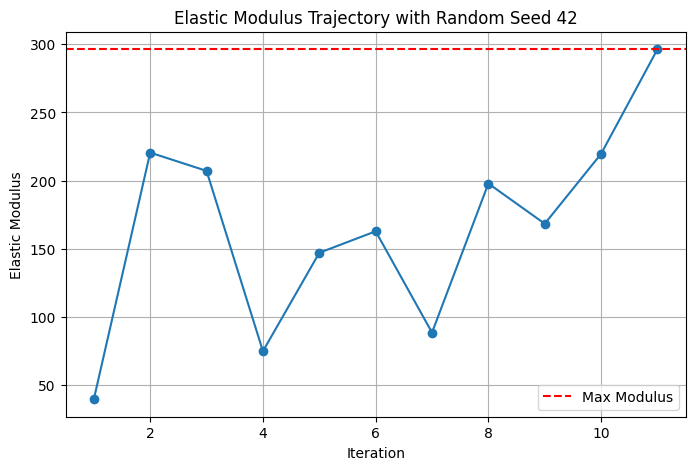

In [201]:
trajectory_df = run_experiment(data_grouped, ranges, random_seed=42)

2025-03-19 17:29:14,454 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Initial observation: Experiment 48


2025-03-19 17:29:24,749 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:29:24,833 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 1: Added new observation (Experiment 63)
Suggestion: Based on the single data point provided, I'll recommend the next experiment to maximize the elastic modulus for your automated membrane synthesis via NIPS.

# Recommended Next Experiment

## Experiment Parameters:
- **Synthesis Method**: Automated (Auto: Yes)
- **Polymer Concentration**: 19.0% (increasing from 17.0%)
- **Heating**: Yes (adding heating during solution preparation)
- **Heating Block Temperature**: 60°C
- **Mixed**: No (continue using pre-mixed polymer solution)
- **Rest Time**: 1 day (adding rest time to allow better polymer chain organization)
- **Coupon-to-Bath Wait Time**: 2 minutes (adding a short evaporation period)
- **Relative Humidity**: 50% (reducing from 82% to a more controlled level)
- **Nitrogen (Side from drop)**: Yes (adding nitrogen flow for better environmental control)
- **Nitrogen (After blade)**: Yes (adding nitrogen flow for controlled evaporation)

## Rationale:
1. **Increased polymer co

2025-03-19 17:29:36,449 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:29:36,582 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 2: Added new observation (Experiment 34)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the two prior experiments, I can make the following observations:

1. Experiment #72 achieved a higher modulus (228.47) compared to Experiment #38 (171.0)
2. Key differences that may have contributed to this improvement:
   - Reduced humidity (50% vs 82%)
   - 1-day rest time vs no rest time
   - Both used the same polymer concentration (17%)

## Recommended Next Experiment Parameters

I recommend the following parameters for the next experiment to maximize modulus:

- **Auto**: Yes (automated synthesis)
- **Heating**: Yes (apply heating during solution preparation)
- **Concentration**: 19% (increase polymer concentration)
- **Heating block temperature**: 60°C
- **Mixed**: No (use pre-mixed solution)
- **Rest time**: 2 days (increase rest time)
- **Coupon-to-Bath Wait Time**: 0.0 minutes (immediate immersion)
- **Relative Humidity**: 40% (further reduce humi

2025-03-19 17:29:44,999 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:29:45,092 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 3: Added new observation (Experiment 66)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the three previous experiments, I can identify several trends that appear to influence the elastic modulus of the membranes:

## Key Observations:
1. **Polymer Concentration**: Higher concentration (17%) yielded higher modulus values (171.0 and 228.47) compared to lower concentration (14%, yielding 88.48)
2. **Rest Time**: 1 day rest time appears beneficial (228.47 with rest vs. 171.0 without rest at same concentration)
3. **Humidity**: Moderate humidity (50%) seems preferable to very high humidity (82%)
4. **Pre-mixing**: Manually pre-mixed solutions performed better than robot-mixed solutions

## Recommended Next Experiment:
- **Polymer Concentration**: 20% (increasing from 17% to explore upper range)
- **Heating**: Yes (introduce heating to potentially improve polymer dissolution)
- **Heating Block Temperature**: 50°C (moderate heating)
- **Mixed**: No (u

2025-03-19 17:29:55,259 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:29:55,378 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 4: Added new observation (Experiment 65)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior observations, I recommend the following experimental parameters to maximize the elastic modulus:

## Recommended Experiment Parameters
- **Synthesis Method**: Automated (Auto: Yes)
- **Polymer Concentration**: 20% (increasing from the 17% that showed good results)
- **Heating**: Yes
- **Heating Block Temperature**: 60°C (increasing from 50°C to potentially improve polymer dissolution)
- **Mixed**: No (use pre-mixed solution as it showed better results in experiment #72)
- **Rest Time**: 2 days (extending from the 1 day that showed good results in experiment #72)
- **Coupon-to-Bath Wait Time**: 0.0 minutes (immediate immersion consistently showed good results)
- **Relative Humidity**: 45% (controlled lower humidity, as experiment #72 with 50% RH showed better results than #38 with 82% RH)
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade

2025-03-19 17:30:04,572 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:30:04,646 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 5: Added new observation (Experiment 39)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior observations, I recommend the following experimental parameters to maximize the elastic modulus:

## Recommended Experiment Parameters
- **Synthesis Method**: Automated (Yes)
- **Polymer Concentration**: 19% (increasing from the 17% that showed good results)
- **Heating**: Yes
- **Heating Block Temperature**: 55°C
- **Mixed**: No (use pre-mixed solution)
- **Rest Time**: 2 days
- **Coupon-to-Bath Wait Time**: 0.0 minutes
- **Relative Humidity**: 45%
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade)**: No

## Rationale
1. The highest modulus (228.47) was observed with 17% polymer concentration, premixed solution, 1 day rest time, and 50% humidity.
2. Increasing the polymer concentration to 19% should further enhance the modulus as higher concentrations typically yield stronger membranes.
3. Adding heating during preparation while using 

2025-03-19 17:30:15,068 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:30:15,184 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 6: Added new observation (Experiment 55)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the provided experimental data, I can identify several trends that suggest how to maximize the elastic modulus:

## Key Observations:
1. Higher polymer concentration correlates with higher modulus:
   - 17.0% concentration yielded the highest modulus values (228.47 and 171.0)
   - 15.0% yielded 140.77
   - 14.0% yielded 88.48
   - 11.63% yielded the lowest values (91.0 and 64.3)

2. Rest time appears beneficial:
   - The highest modulus (228.47) was achieved with 1 day rest time
   - Experiments with 1 day rest generally outperformed those with 0 days

3. Premixing vs. robot mixing:
   - The highest modulus (228.47) used premixed solution
   - Robot-mixed solutions generally showed lower modulus

4. Humidity impact:
   - Moderate humidity (50%) appears optimal compared to very high humidity (82%)

## Recommended Next Experiment:
- **Polymer Concentration**: 

2025-03-19 17:30:25,227 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:30:25,307 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 7: Added new observation (Experiment 54)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior experimental data, I recommend the following parameters for the next experiment to maximize the elastic modulus:

## Recommended Experiment Parameters
- **Auto**: Yes (automated synthesis)
- **Polymer Concentration**: 18.0% (increasing from the 17.0% that showed good results)
- **Heating**: No (ambient temperature of 25°C)
- **Mixed**: No (use pre-mixed polymer solution)
- **Rest time**: 2 days (extending from the 1 day that showed good results)
- **Coupon-to-Bath Wait Time**: 0.5 minutes
- **Relative Humidity**: 50% (controlled environment)
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade)**: Yes

## Rationale
1. The highest modulus (228.47) was observed in Experiment #72 with 17% concentration, premixed solution, 1 day rest, and 50% humidity.
2. Increasing the concentration slightly to 18% may further enhance the modulus, as higher c

2025-03-19 17:30:35,245 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:30:35,365 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 8: Added new observation (Experiment 60)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior experimental observations, I recommend the following parameters for the next experiment to maximize the elastic modulus:

## Recommended Experiment Parameters
- **Synthesis Method**: Automated (Auto: Yes)
- **Polymer Concentration**: 17.0% (the highest concentration that showed good results)
- **Heating**: No (ambient temperature of 25°C)
- **Mixed**: No (use premixed polymer solution)
- **Rest time**: 1 day
- **Coupon-to-Bath Wait Time**: 0.17 minutes (10.2 seconds)
- **Relative Humidity**: 50%
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade)**: Yes

## Rationale
1. The highest modulus (228.47) was observed in Experiment #72 with 17% concentration, 1 day rest time, and 50% humidity.
2. Experiment #50 also showed high modulus (197.84) with 17% concentration, nitrogen after blade, and a short wait time (0.17 min).
3. Higher polymer con

2025-03-19 17:30:44,194 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:30:44,300 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 9: Added new observation (Experiment 59)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the experimental data provided, I recommend the following parameters for the next experiment to maximize the elastic modulus:

## Recommended Experiment Parameters
- **Synthesis Method**: Automated (Yes)
- **Polymer Concentration**: 17.0%
- **Heating**: No (ambient temperature of 25°C)
- **Mixed**: No (use premixed polymer solution)
- **Rest time**: 1 day
- **Coupon-to-Bath Wait Time**: 10.0 minutes
- **Relative Humidity**: 60%
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade)**: Yes

## Rationale
1. The highest modulus (272.22) was observed in Experiment #56, which used 17% polymer concentration, no heating, premixed solution, 10 minutes wait time, and nitrogen after blade casting.

2. A moderate humidity (around 50-60%) appears beneficial compared to very high humidity (>70%).

3. The 1-day rest time is chosen based on Experiment #72, which sh

2025-03-19 17:30:53,478 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Stopping early at iteration 10 - Max modulus found.


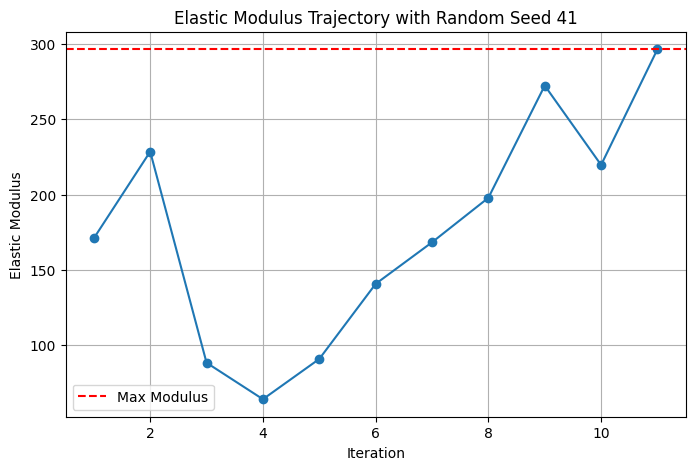

In [202]:
trajectory_df = run_experiment(data_grouped, ranges, random_seed=41)

2025-03-19 17:30:53,682 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Initial observation: Experiment 58


2025-03-19 17:31:07,309 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:31:07,434 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 1: Added new observation (Experiment 35)
Suggestion: Based on the provided experimental data, I'll recommend the next experiment to maximize the elastic modulus for your membrane synthesis.

# Recommended Next Experiment

## Experiment Parameters:

- **Synthesis Method**: Automated robotic system (Auto: Yes)
- **Polymer Solution**: 19.0% polysulfone in PolarClean solvent (increased concentration)
- **Solution Preparation**: With heating (Heating: Yes), heating block temperature: 60°C
- **Solution Preparation Method**: Robot-mixed (Mixed: Yes)
- **Solution Rest Time**: 1 day
- **Casting Conditions**:
  - 8.0 minute wait time between coupon casting and NIPS bath immersion
  - 65% relative humidity during synthesis
  - No nitrogen flow during drop-casting (Nitrogen Side from drop: No)
  - Laminar dry nitrogen flow applied after blade-casting (Nitrogen After blade: Yes)

## Rationale:

1. **Increased polymer concentration** (from 17% to 19%): Higher polymer concentrations typical

2025-03-19 17:31:16,404 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:31:16,483 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 2: Added new observation (Experiment 54)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the two previous experiments, I recommend the following parameters for the next experiment to maximize the elastic modulus:

## Recommended Experimental Parameters

- **Synthesis Method**: Automated (Auto: Yes)
- **Polymer Concentration**: 18.0% polysulfone
- **Solution Preparation**: 
  - Heating: Yes
  - Heating block temperature: 40°C
  - Mixed: No (manually premixed)
- **Solution Rest Time**: 2 days
- **Casting Conditions**:
  - Coupon-to-Bath Wait Time: 8.0 minutes
  - Relative Humidity: 65%
  - Nitrogen (Side from drop): Yes
  - Nitrogen (After blade): Yes

## Rationale

1. **Increased Polymer Concentration**: The higher modulus was observed with 17% concentration compared to 14%. Increasing to 18% may further enhance mechanical properties.

2. **Adding Heat During Preparation**: This could improve polymer dissolution and solution homogeneity, potentia

2025-03-19 17:31:26,636 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:31:26,769 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 3: Added new observation (Experiment 59)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the three previous experiments and their resulting elastic modulus values, I recommend the following parameters for the next experiment to maximize modulus:

## Recommended Experiment Parameters
- **Auto**: Yes (Automated synthesis)
- **Heating**: No (No heating during solution preparation)
- **Concentration**: 18.0% (Increasing from the 17.0% that showed good results)
- **Heating block temperature**: 25°C (Ambient temperature)
- **Mixed**: No (Use manually premixed solution)
- **Rest time**: 0 days (Use immediately after preparation)
- **Coupon-to-Bath Wait Time**: 10.0 minutes
- **Relative Humidity**: 68%
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade)**: Yes

## Rationale
1. The highest modulus (211.51) was observed in Experiment 54, which used 17% concentration, 10-minute wait time, 68% humidity, and nitrogen flow after blade-casting.
2. I

2025-03-19 17:31:36,667 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:31:36,746 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 4: Added new observation (Experiment 60)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the previous experimental data, I recommend the following parameters for the next experiment to maximize the elastic modulus:

## Recommended Experiment Parameters
- **Auto**: Yes (Automated synthesis)
- **Heating**: No (Ambient temperature 25°C)
- **Concentration**: 18.0% polysulfone
- **Heating block temperature**: 25°C (ambient)
- **Mixed**: No (Use premixed solution)
- **Rest time**: 0 days (Use immediately)
- **Coupon-to-Bath Wait Time**: 10.0 minutes
- **Relative Humidity**: 68%
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade)**: Yes

## Rationale
1. The highest modulus (219.62) was observed in experiment #55, which used 17% concentration, 10-minute wait time, 68% humidity, and nitrogen after blade casting.

2. I'm recommending a slight increase in polymer concentration to 18% because:
   - Higher polymer concentrations generally lead to 

2025-03-19 17:31:46,896 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:31:47,044 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 5: Added new observation (Experiment 55)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the previous experimental data, I recommend the following parameters for the next experiment to maximize the elastic modulus:

## Recommended Experiment Parameters
- **Auto**: Yes (automated synthesis)
- **Polymer Concentration**: 18.0% (increasing from 17.0% as higher concentration showed better results)
- **Heating**: No (ambient temperature 25°C)
- **Mixed**: No (manually premixed solution)
- **Rest time**: 0 days (use immediately after preparation)
- **Coupon-to-Bath Wait Time**: 10.0 minutes
- **Relative Humidity**: 55% (targeting the mid-range between the successful 58% and lower values)
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade)**: Yes (apply laminar nitrogen flow after blade casting)

## Rationale
1. The highest modulus (272.22) was observed in experiment #56 with 17% concentration, 10-minute wait time, 58% humidity, and nitrogen 

2025-03-19 17:31:56,873 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Stopping early at iteration 6 - Max modulus found.


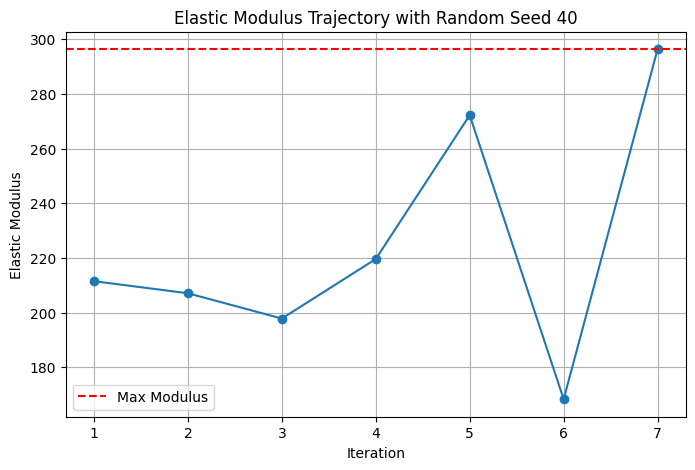

In [203]:
trajectory_df = run_experiment(data_grouped, ranges, random_seed=40)

2025-03-19 17:31:57,033 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Initial observation: Experiment 26


2025-03-19 17:32:05,469 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:32:05,599 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 1: Added new observation (Experiment 34)
Suggestion: Based on the provided experimental data for experiment #21, I'll recommend the next experiment to maximize the elastic modulus.

# Recommended Next Experiment

I recommend the following parameters for your next experiment to maximize the elastic modulus:

- **Concentration**: 15.0% polysulfone (increase from 12.0%)
- **Auto**: Yes (maintain automated synthesis)
- **Heating**: Yes (introduce heating during mixing)
- **Heating block temperature**: 40°C
- **Mixed**: Yes (use robot mixing)
- **Rest time**: 2 days (increase from 1 day)
- **Coupon-to-Bath Wait Time**: 2.0 minutes (increase from 0.0 minutes)
- **Relative Humidity**: 40% (decrease from 49%)
- **Nitrogen (Side from drop)**: Yes (introduce nitrogen flow)
- **Nitrogen (After blade)**: Yes (introduce nitrogen flow)

## Rationale
1. **Increasing polymer concentration** (12% → 15%) should increase chain entanglement and likely improve mechanical properties including modu

2025-03-19 17:32:12,599 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:32:12,679 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 2: Added new observation (Experiment 40)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the two experiments provided, I can observe that increasing the polymer concentration from 12.0% to 14.0% resulted in a significant improvement in elastic modulus (from 42.74 to 88.48 MPa). All other parameters remained constant between these experiments.

For the next experiment, I recommend:

## Proposed Experimental Parameters
- **Auto**: Yes (automated synthesis)
- **Heating**: No (room temperature mixing)
- **Concentration**: 16.0% (increasing from 14.0% to continue the trend)
- **Heating block temperature**: 25°C (room temperature)
- **Mixed**: Yes (robot-mixed)
- **Rest time**: 1 day (maintain consistency)
- **Coupon-to-Bath Wait Time**: 0.0 min (immediate immersion)
- **Relative Humidity**: 49% (maintain consistency)
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade)**: No

## Rationale
The data shows a clear positive correlation between 

2025-03-19 17:32:21,116 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:32:21,242 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 3: Added new observation (Experiment 35)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the three experiments provided, I can observe a clear trend that increasing polymer concentration leads to significantly higher elastic modulus values:

- Experiment #21: 12.0% concentration → 42.74 MPa modulus
- Experiment #22: 14.0% concentration → 88.48 MPa modulus
- Experiment #23: 16.0% concentration → 162.78 MPa modulus

This suggests a strong positive correlation between polymer concentration and modulus, with the relationship potentially being non-linear (as the increase from 14% to 16% yielded a larger modulus improvement than from 12% to 14%).

## Recommended Next Experiment

I recommend the following parameters for the next experiment to maximize modulus:

- **Auto**: Yes (automated synthesis)
- **Heating**: No (room temperature mixing)
- **Concentration**: 18.0% (increasing from previous maximum of 16%)
- **Heating block temperature**: 25°C (room

2025-03-19 17:32:29,483 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:32:29,593 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 4: Added new observation (Experiment 41)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the previous experimental results, I can identify several trends that appear to influence the elastic modulus:

1. **Polymer Concentration**: There's a clear positive correlation between concentration and modulus:
   - 12.0% → 42.74 MPa
   - 14.0% → 88.48 MPa
   - 16.0% → 162.78 MPa

2. **Nitrogen Flow**: Experiment #29 with nitrogen flow from the side during drop-casting showed significantly higher modulus (207.09 MPa) compared to experiment #22 (88.48 MPa) with identical concentration (14.0%).

3. **Relative Humidity**: A slight increase in humidity (from 49% to 54%) coincided with higher modulus in experiment #29.

## Recommended Next Experiment Parameters:

- **Polymer Concentration**: 18.0% (increasing from the highest tested value of 16.0%)
- **Automated**: Yes
- **Heating**: No (room temperature mixing at 25°C)
- **Mixed**: Yes (robot-mixed)
- **Rest 

2025-03-19 17:32:38,702 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:32:38,824 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 5: Added new observation (Experiment 28)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the previous experimental results, I can identify several trends that appear to influence the elastic modulus:

1. **Polymer concentration**: There's a clear positive correlation between concentration and modulus:
   - 12.0% → 42.74 MPa
   - 14.0% → 88.48 MPa and 207.09 MPa (with N₂)
   - 16.0% → 162.78 MPa and 220.51 MPa (with N₂)

2. **Nitrogen flow during drop casting**: Experiments with nitrogen flow from the side during drop casting showed significantly higher modulus values:
   - Exp #29 (14%, with N₂): 207.09 MPa vs Exp #22 (14%, no N₂): 88.48 MPa
   - Exp #30 (16%, with N₂): 220.51 MPa vs Exp #23 (16%, no N₂): 162.78 MPa

3. **Relative humidity**: Slightly higher humidity (54% vs 49%) appears beneficial when combined with nitrogen flow.

## Recommended Next Experiment

I recommend the following parameters for the next experiment to maximize modulus:


2025-03-19 17:32:48,813 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:32:48,899 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 6: Added new observation (Experiment 66)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the previous experimental data, I can identify several trends that influence the elastic modulus of the membranes:

1. **Polymer concentration**: There's a clear positive correlation between concentration and modulus:
   - 12% → 42.74 MPa (Exp #21) and 147.0 MPa (Exp #28 with N₂)
   - 14% → 88.48 MPa (Exp #22) and 207.09 MPa (Exp #29 with N₂)
   - 16% → 162.78 MPa (Exp #23) and 220.51 MPa (Exp #30 with N₂)

2. **Nitrogen flow during drop casting**: Significantly increases modulus:
   - Without N₂: 42.74, 88.48, 162.78 MPa
   - With N₂: 147.0, 207.09, 220.51 MPa

3. **Relative humidity**: Slightly higher humidity (54% vs 49%) appears beneficial

## Recommended Next Experiment:

I recommend testing a higher polymer concentration with the following parameters:

- **Experiment ID**: Next sequential number
- **Synthesis Method**: Automated NIPS
- **Polymer Concen

2025-03-19 17:33:01,258 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:33:01,378 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 7: Added new observation (Experiment 65)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the experimental data provided, I can identify several trends that appear to influence the elastic modulus of the membranes:

1. **Polymer concentration**: There's a clear positive correlation between concentration and modulus:
   - 12.0% → 42.74 MPa (Exp #21) and 147.0 MPa (Exp #28 with N₂)
   - 14.0% → 88.48 MPa (Exp #22) and 207.09 MPa (Exp #29 with N₂)
   - 16.0% → 162.78 MPa (Exp #23) and 220.51 MPa (Exp #30 with N₂)

2. **Nitrogen flow during drop casting**: Experiments with nitrogen flow from the side consistently show higher modulus values compared to identical conditions without nitrogen flow.

3. **Relative humidity**: Experiments at 54% RH appear to yield higher modulus than those at 49% RH.

4. **Heating**: The heated experiment (#16) with 11.63% concentration yielded 64.3 MPa, which is higher than expected for that concentration based on other d

2025-03-19 17:33:10,861 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:33:10,954 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 8: Added new observation (Experiment 54)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior observations, I can identify several trends that appear to influence the elastic modulus of the membranes:

1. **Polymer concentration**: Higher concentrations (16%) consistently yield higher modulus values (162.78, 220.51 MPa) compared to lower concentrations (12%, 11.63%).

2. **Nitrogen flow during drop-casting**: Experiments with nitrogen flow from the side during drop-casting (#28, #29, #30) showed significantly higher modulus values (147.0, 207.09, 220.51 MPa).

3. **Relative humidity**: Controlled humidity around 54% appears beneficial when combined with nitrogen flow.

4. **Heating**: The effect is less clear, but most high-modulus membranes were prepared without heating.

## Recommended Next Experiment Parameters:

- **Polymer Concentration**: 18% (pushing toward the upper end of the observed range to maximize polymer content)
- **Synthesi

2025-03-19 17:33:21,118 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:33:21,271 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 9: Added new observation (Experiment 55)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the previous experimental data, I recommend the following parameters for the next experiment to maximize the elastic modulus:

## Recommended Experimental Parameters:
- **Concentration**: 18.0% polysulfone (increasing from the highest tested value of 17.0%)
- **Auto**: Yes (fully automated synthesis)
- **Heating**: No (room temperature mixing at 25°C)
- **Mixed**: No (use premixed solution)
- **Rest time**: 0 days (use immediately)
- **Coupon-to-Bath Wait Time**: 0.17 minutes (10.2 seconds)
- **Relative Humidity**: 70%
- **Nitrogen (Side from drop)**: Yes (apply during drop-casting)
- **Nitrogen (After blade)**: Yes (apply after blade-casting)

## Rationale:
1. The data shows a clear trend that higher polymer concentration correlates with higher modulus (12% → 42.74, 14% → 88.48, 16% → 162.78, 17% → 197.84).

2. Nitrogen flow during processing appears benefi

2025-03-19 17:33:30,310 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:33:30,378 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 10: Added new observation (Experiment 60)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior observations, I can identify several trends that influence the elastic modulus of the membranes:

1. **Polymer concentration**: Higher concentrations (16-17%) generally yield higher modulus values
2. **Nitrogen flow**: Applying nitrogen from the side during drop-casting appears beneficial
3. **Relative humidity**: Higher humidity (54-70%) seems to correlate with higher modulus values
4. **Wait time**: Short wait times (0-0.17 min) generally perform well

For the next experiment, I recommend the following parameters:

## Recommended Experiment Parameters
- **Auto**: Yes (fully automated synthesis)
- **Heating**: No (room temperature mixing)
- **Concentration**: 18.0% (slightly higher than previous best)
- **Heating block temperature**: 25°C (ambient)
- **Mixed**: No (use premixed solution)
- **Rest time**: 0 days (use immediately)
- **Coupon-to-Bat

2025-03-19 17:33:42,408 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:33:42,535 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 11: Added new observation (Experiment 59)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior observations, I recommend the following experimental parameters to maximize the elastic modulus:

## Recommended Experiment Parameters:
- **Polymer Concentration**: 18.0% (increasing from the highest tested value of 17.0%)
- **Heating**: No (room temperature mixing at 25°C)
- **Mixed**: No (use premixed solution)
- **Rest time**: 0 days (use immediately)
- **Coupon-to-Bath Wait Time**: 10.0 minutes
- **Relative Humidity**: 58%
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade)**: Yes

## Rationale:
1. **Polymer Concentration**: The data shows a clear trend that higher polymer concentration correlates with higher modulus (Exp #23 with 16% had 162.78 MPa, Exp #30 with 16% had 220.51 MPa, Exp #56 with 17% had 272.22 MPa). Increasing to 18% should further enhance modulus.

2. **Wait Time**: Experiment #56 with the highest modulus (272.22 M

2025-03-19 17:33:54,932 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:33:55,060 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 12: Added new observation (Experiment 43)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the previous experimental data, I recommend the following parameters for the next experiment to maximize the elastic modulus:

## Recommended Experiment Parameters:
- **Synthesis Method**: Automated NIPS
- **Polymer Concentration**: 18.0% (increasing from the highest tested value of 17.0%)
- **Heating**: No (room temperature 25°C)
- **Mixed**: No (use premixed solution)
- **Rest time**: 0 days (use immediately)
- **Coupon-to-Bath Wait Time**: 10.0 minutes
- **Relative Humidity**: 55-60% (targeting 58%)
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade)**: Yes

## Rationale:
1. **Higher polymer concentration**: The data shows a clear trend where higher polymer concentrations (16-17%) produced higher modulus values. Experiment #56 with 17% concentration achieved the highest modulus (272.22).

2. **Extended wait time**: The 10-minute wait time befo

2025-03-19 17:34:04,352 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Stopping early at iteration 13 - Max modulus found.


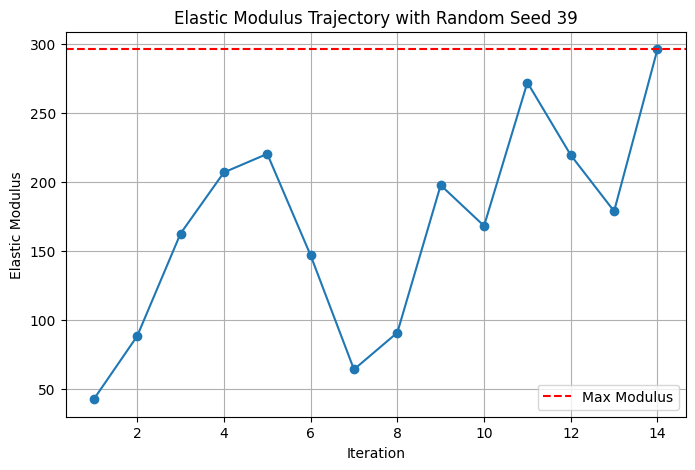

In [204]:
trajectory_df = run_experiment(data_grouped, ranges, random_seed=39)

2025-03-19 17:34:04,503 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Initial observation: Experiment 53


2025-03-19 17:34:18,271 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Iteration 1: Added new observation (Experiment 54)
Suggestion: Based on the prior observation, I'll analyze the parameters that might influence the elastic modulus and recommend the next experiment to maximize this property.

# Recommendation for Next Experiment

Based on the single data point provided (Experiment #49), I recommend the following parameters for the next experiment to potentially maximize the elastic modulus:

- **Synthesis Method**: Automated (Auto: Yes)
- **Polymer Concentration**: 19.0% polysulfone (increasing from 17.0%)
- **Heating**: Yes (introduce heating during solution preparation)
- **Heating Block Temperature**: 60°C
- **Solution Mixing**: Premixed manually (Mixed: No)
- **Rest Time**: 1 day
- **Coupon-to-Bath Wait Time**: 8 minutes (slightly reduced from 10 minutes)
- **Relative Humidity**: 85% (slightly lower than previous 95%)
- **Nitrogen (Side from drop)**: Yes (maintain this parameter)
- **Nitrogen (After blade)**: Yes (add this feature)

## Rationale:
1

2025-03-19 17:34:18,489 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-19 17:34:29,223 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:34:29,343 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 2: Added new observation (Experiment 55)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the two previous experiments (ID 49 and 50), I'll analyze the parameters that appear to influence the elastic modulus and recommend the next experimental setup.

## Analysis of Previous Results:
- Experiment 49: Modulus = 228.31 MPa (higher)
  - 17% polymer concentration
  - No heating (25°C)
  - Premixed solution
  - No rest time (0 days)
  - 10-minute coupon-to-bath wait time
  - 95% relative humidity
  - Nitrogen flow during drop-casting only
  - No nitrogen after blade-casting

- Experiment 50: Modulus = 197.84 MPa (lower)
  - 17% polymer concentration
  - No heating (25°C)
  - Premixed solution
  - No rest time (0 days)
  - 0.17-minute coupon-to-bath wait time
  - 70% relative humidity
  - No nitrogen during drop-casting
  - Nitrogen flow after blade-casting

## Key Observations:
1. The higher modulus (228.31 MPa) was achieved with longer coupon-to-bath

2025-03-19 17:34:40,421 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:34:40,548 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 3: Added new observation (Experiment 60)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the three previous experiments (IDs 49, 50, and 51), I've analyzed the relationship between experimental parameters and the elastic modulus values:

| ID | Concentration | Rest time | Coupon-to-Bath Wait Time | Humidity | N₂ (Side) | N₂ (After) | Modulus |
|----|--------------|-----------|--------------------------|----------|-----------|------------|---------|
| 49 | 17.0%        | 0 days    | 10 minutes               | 95%      | Yes       | No         | 228.31  |
| 50 | 17.0%        | 0 days    | 0.17 minutes             | 70%      | No        | Yes        | 197.84  |
| 51 | 17.0%        | 0 days    | 1.0 minute               | 70%      | No        | Yes        | 168.33  |

## Recommended Next Experiment:

- **Concentration**: 17.0% (maintain consistency with previous experiments)
- **Heating**: No (25°C ambient temperature)
- **Mixed**: No (manually prem

2025-03-19 17:34:49,911 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
2025-03-19 17:34:49,995 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 4: Added new observation (Experiment 59)
Suggestion: # Recommendation for Next Experiment to Maximize Modulus

Based on the prior observations, I recommend the following experimental parameters to maximize the elastic modulus:

## Experiment Parameters
- **Auto**: Yes (use automated robotic system)
- **Heating**: No (ambient temperature of 25°C)
- **Concentration**: 17.0% polysulfone in PolarClean solvent
- **Heating block temperature**: 25°C
- **Mixed**: No (manually premixed solution)
- **Rest time**: 0 days (use immediately after preparation)
- **Coupon-to-Bath Wait Time**: 10 minutes
- **Relative Humidity**: 60%
- **Nitrogen (Side from drop)**: No
- **Nitrogen (After blade)**: Yes

## Rationale
1. The highest modulus (272.22) was observed in experiment #56, which used a 10-minute coupon-to-bath wait time at 58% relative humidity.
2. Experiment #49 with 10-minute wait time and 95% humidity also showed high modulus (228.31), but lower than #56.
3. Shorter wait times (experi

2025-03-19 17:34:58,751 - INFO - HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


Stopping early at iteration 5 - Max modulus found.


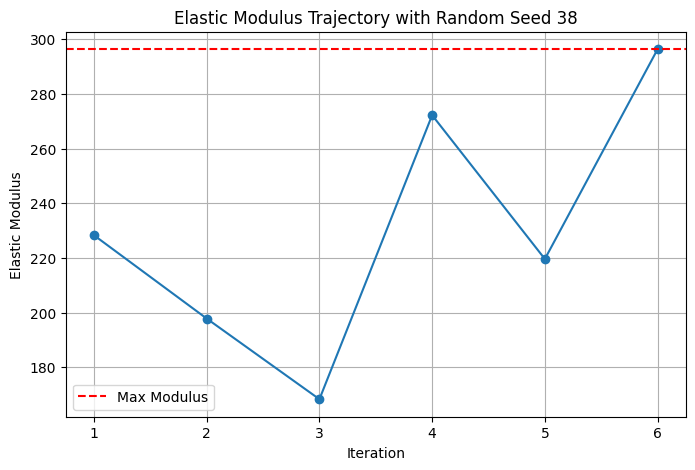

In [205]:
trajectory_df = run_experiment(data_grouped, ranges, random_seed=38)

In [21]:
def plot_multiple_trajectories(trajectory_dfs, labels=None, title = "Model"):
    """
    Plots multiple trajectory DataFrames showing the evolution of Elastic Modulus over iterations.

    Parameters:
    - trajectory_dfs: List of Pandas DataFrames containing trajectory data.
    - labels: List of labels corresponding to each trajectory (optional).

    Returns:
    - A plot displaying modulus vs. iteration for each trajectory.
    """
    plt.figure(figsize=(8, 5))

    for i, df in enumerate(trajectory_dfs):
        label = labels[i] if labels else f"Trajectory {i+1}"
        plt.plot(df["Iteration"], df["Observed Elastic Modulus"], marker='o', linestyle='-', label=label)
        plt.axvline(x=df["Iteration"].iloc[-1], color='g', linestyle='--', alpha=0.7)
    max_modulus = trajectory_dfs[0]["Max Modulus in Dataset"].max()
    plt.axhline(y=max_modulus, color='r', linestyle='--', label='Max Modulus', alpha=0.7)
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Elastic Modulus (Bar)", fontsize=14)
    plt.title(f"{title} Active Learning Trajectories", fontsize=16)
    plt.legend(loc = 'lower right')
    plt.grid(True)
    plt.show()



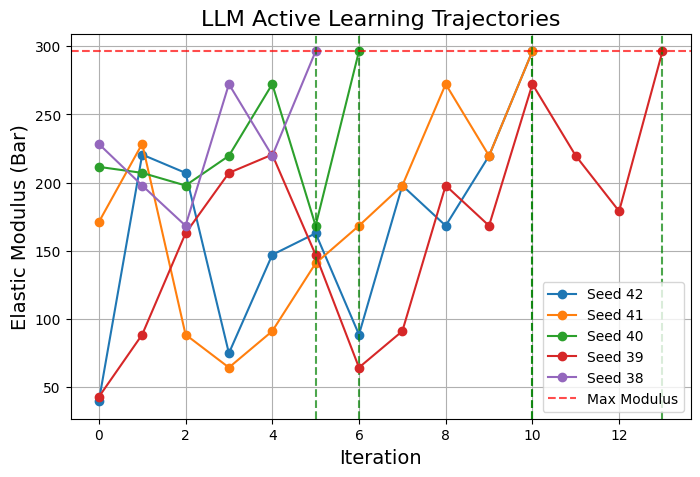

In [69]:
llm_randomseed42 = pd.read_csv("llm_experiment_trajectory_seed42.csv")
llm_randomseed41 = pd.read_csv("llm_experiment_trajectory_seed41.csv")
llm_randomseed40 = pd.read_csv("llm_experiment_trajectory_seed40.csv")
llm_randomseed39 = pd.read_csv("llm_experiment_trajectory_seed39.csv")
llm_randomseed38 = pd.read_csv("llm_experiment_trajectory_seed38.csv")

plot_multiple_trajectories([llm_randomseed42, llm_randomseed41, llm_randomseed40, llm_randomseed39, llm_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="LLM")

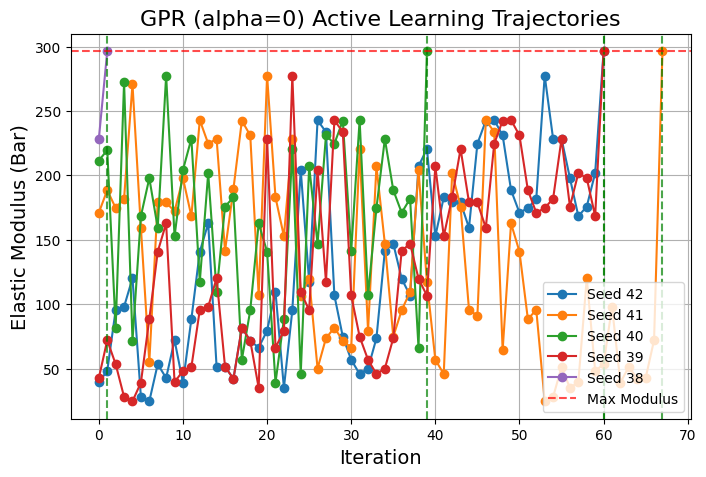

In [80]:
gpr0_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha0_seed42.csv")
gpr0_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha0_seed41.csv")
gpr0_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha0_seed40.csv")
gpr0_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha0_seed39.csv")
gpr0_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha0_seed38.csv")

plot_multiple_trajectories([gpr0_randomseed42, gpr0_randomseed41, gpr0_randomseed40, gpr0_randomseed39, gpr0_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=0)")

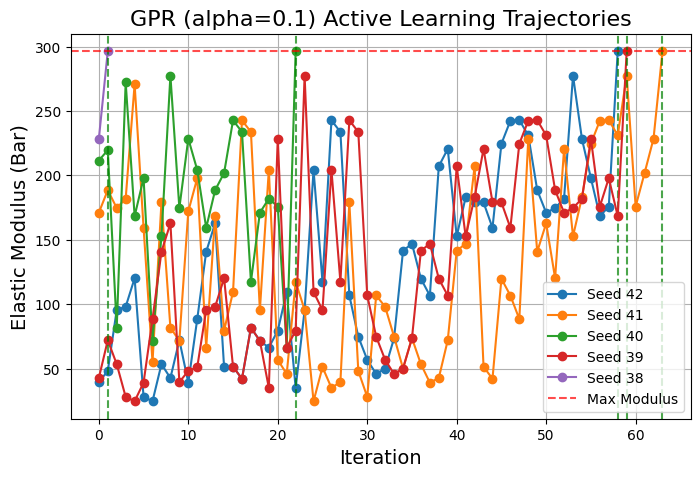

In [81]:
gpr01_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha0.1_seed42.csv")
gpr01_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha0.1_seed41.csv")
gpr01_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha0.1_seed40.csv")
gpr01_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha0.1_seed39.csv")
gpr01_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha0.1_seed38.csv")


plot_multiple_trajectories([gpr01_randomseed42, gpr01_randomseed41, gpr01_randomseed40, gpr01_randomseed39, gpr01_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=0.1)")

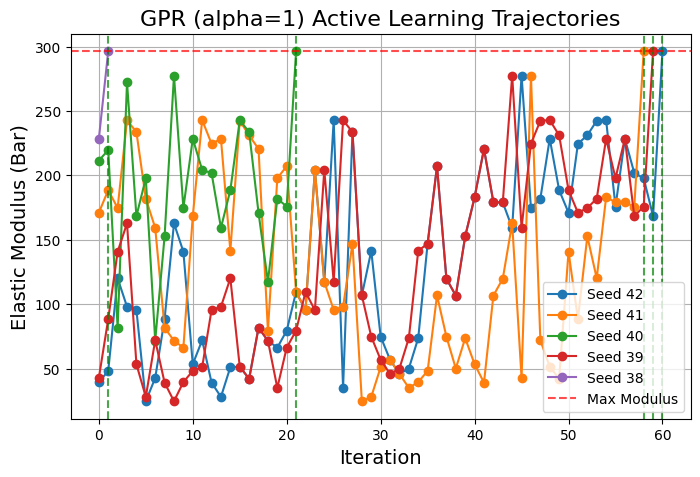

In [25]:
gpr1_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha1_seed42.csv")
gpr1_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha1_seed41.csv")
gpr1_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha1_seed40.csv")
gpr1_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha1_seed39.csv")
gpr1_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha1_seed38.csv")

plot_multiple_trajectories([gpr1_randomseed42, gpr1_randomseed41, gpr1_randomseed40, gpr1_randomseed39, gpr1_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=1)")

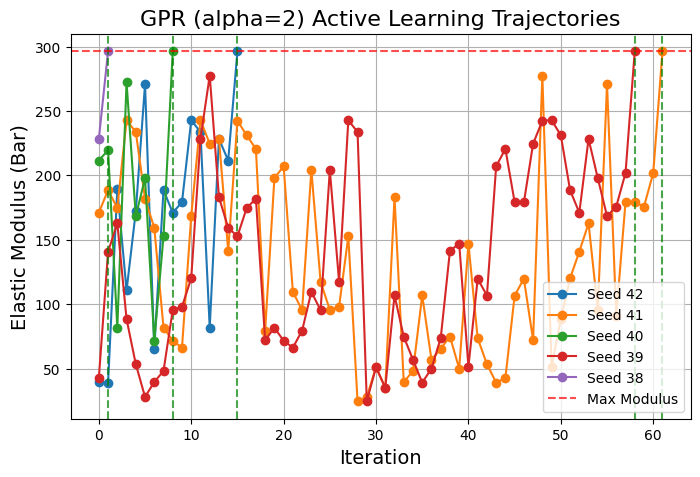

In [64]:
gpr2_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha2_seed42.csv")
gpr2_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha2_seed41.csv")
gpr2_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha2_seed40.csv")
gpr2_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha2_seed39.csv")
gpr2_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha2_seed38.csv")

plot_multiple_trajectories([gpr2_randomseed42, gpr2_randomseed41, gpr2_randomseed40, gpr2_randomseed39, gpr2_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=2)")

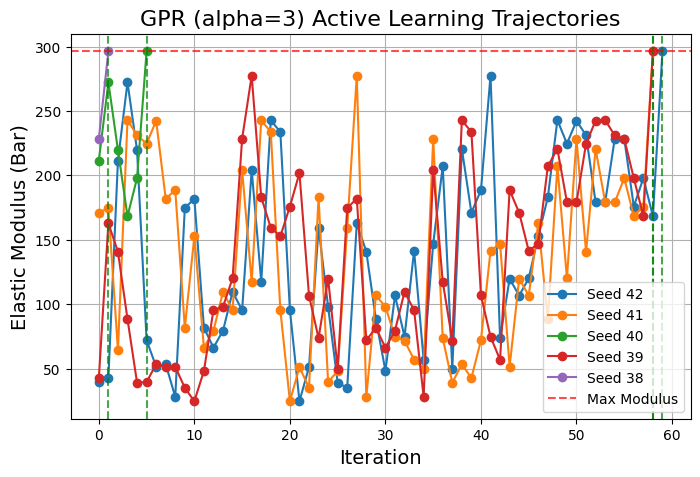

In [26]:
gpr3_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha3_seed42.csv")
gpr3_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha3_seed41.csv")
gpr3_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha3_seed40.csv")
gpr3_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha3_seed39.csv")
gpr3_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha3_seed38.csv")

plot_multiple_trajectories([gpr3_randomseed42, gpr3_randomseed41, gpr3_randomseed40, gpr3_randomseed39, gpr3_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=3)")

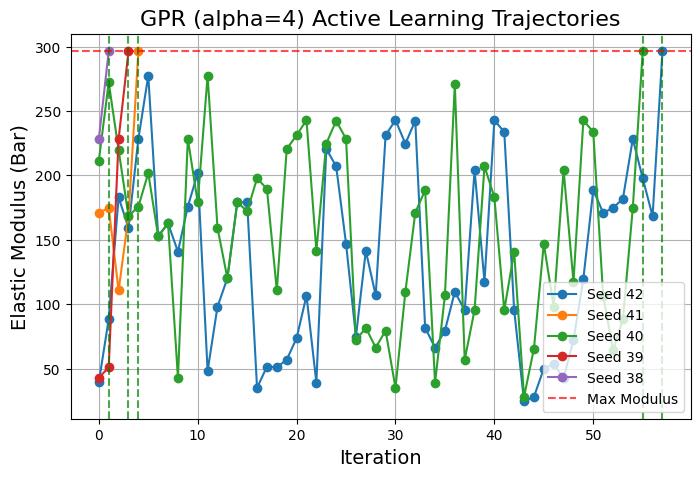

In [78]:
gpr4_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha4_seed42.csv")
gpr4_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha4_seed41.csv")
gpr4_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha4_seed40.csv")
gpr4_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha4_seed39.csv")
gpr4_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha4_seed38.csv")

plot_multiple_trajectories([gpr4_randomseed42, gpr4_randomseed41, gpr4_randomseed40, gpr4_randomseed39, gpr4_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=4)")

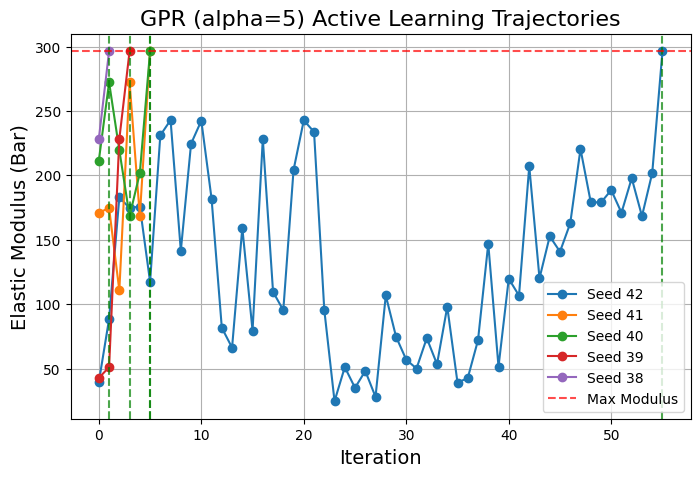

In [27]:
gpr5_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha5_seed42.csv")
gpr5_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha5_seed41.csv")
gpr5_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha5_seed40.csv")
gpr5_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha5_seed39.csv")
gpr5_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha5_seed38.csv")

plot_multiple_trajectories([gpr5_randomseed42, gpr5_randomseed41, gpr5_randomseed40, gpr5_randomseed39, gpr5_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=5)")

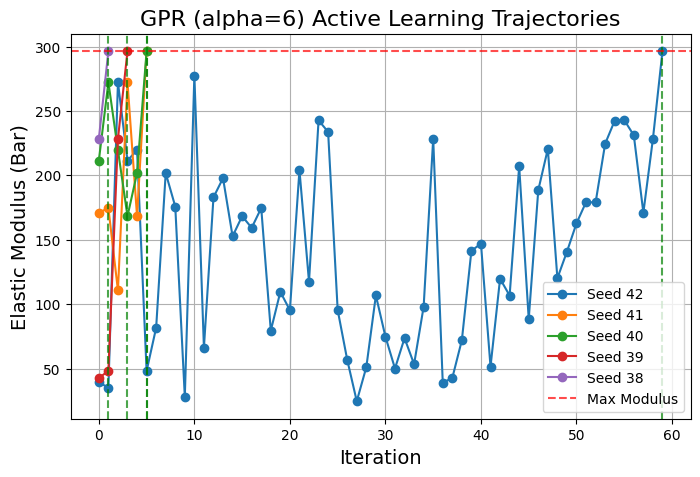

In [39]:
gpr6_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha6_seed42.csv")
gpr6_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha6_seed41.csv")
gpr6_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha6_seed40.csv")
gpr6_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha6_seed39.csv")
gpr6_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha6_seed38.csv")

plot_multiple_trajectories([gpr6_randomseed42, gpr6_randomseed41, gpr6_randomseed40, gpr6_randomseed39, gpr6_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=6)")

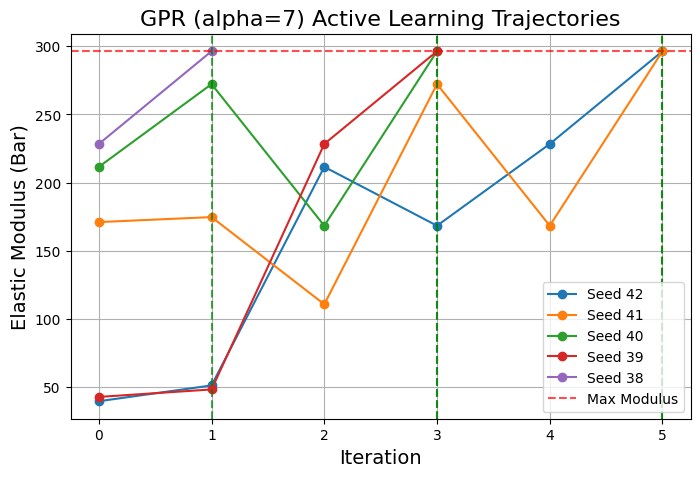

In [45]:
gpr7_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha7_seed42.csv")
gpr7_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha7_seed41.csv")
gpr7_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha7_seed40.csv")
gpr7_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha7_seed39.csv")
gpr7_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha7_seed38.csv")

plot_multiple_trajectories([gpr7_randomseed42, gpr7_randomseed41, gpr7_randomseed40, gpr7_randomseed39, gpr7_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=7)")

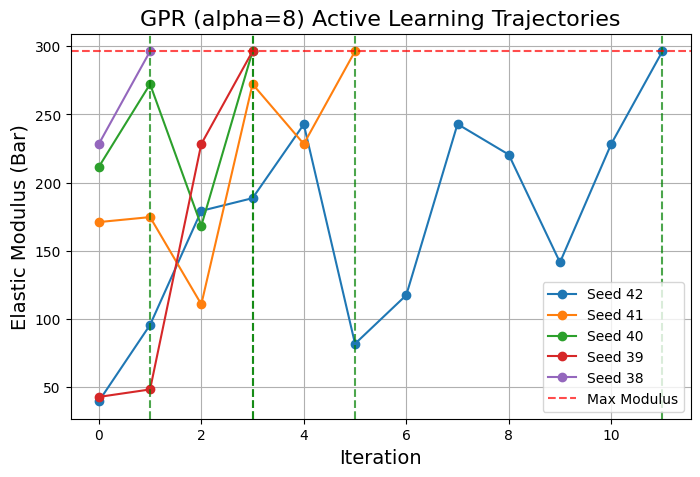

In [46]:
gpr8_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha8_seed42.csv")
gpr8_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha8_seed41.csv")
gpr8_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha8_seed40.csv")
gpr8_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha8_seed39.csv")
gpr8_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha8_seed38.csv")

plot_multiple_trajectories([gpr8_randomseed42, gpr8_randomseed41, gpr8_randomseed40, gpr8_randomseed39, gpr8_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=8)")


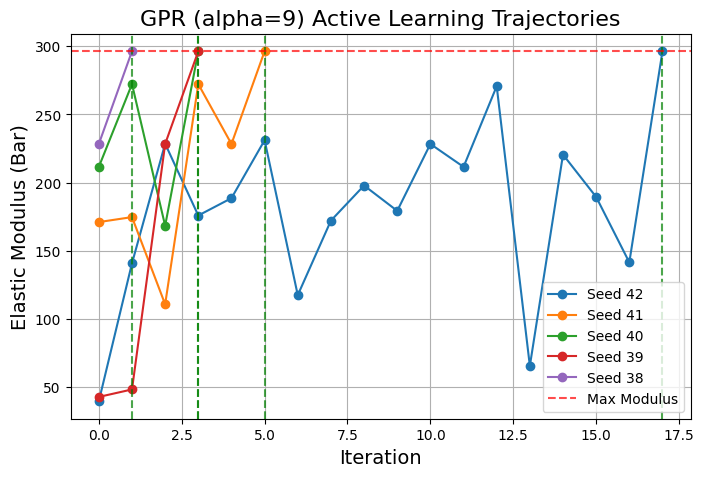

In [63]:
gpr9_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha9_seed42.csv")
gpr9_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha9_seed41.csv")
gpr9_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha9_seed40.csv")
gpr9_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha9_seed39.csv")
gpr9_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha9_seed38.csv")

plot_multiple_trajectories([gpr9_randomseed42, gpr9_randomseed41, gpr9_randomseed40, gpr9_randomseed39, gpr9_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=9)")

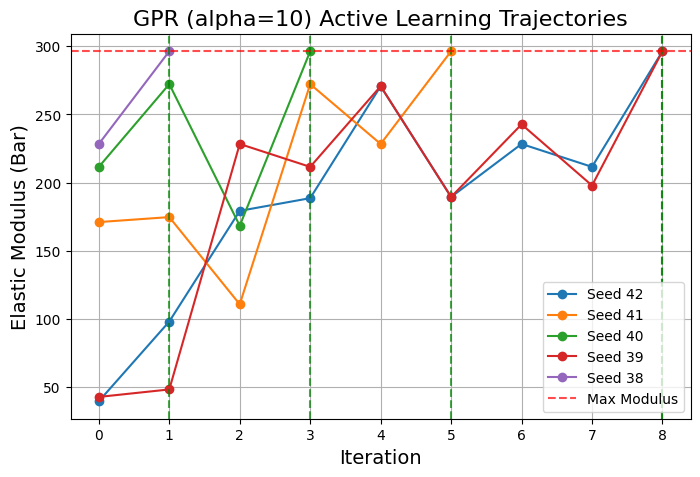

In [82]:
gpr10_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha10_seed42.csv")
gpr10_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha10_seed41.csv")
gpr10_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha10_seed40.csv")
gpr10_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha10_seed39.csv")
gpr10_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha10_seed38.csv")

plot_multiple_trajectories([gpr10_randomseed42, gpr10_randomseed41, gpr10_randomseed40, gpr10_randomseed39, gpr10_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=10)")

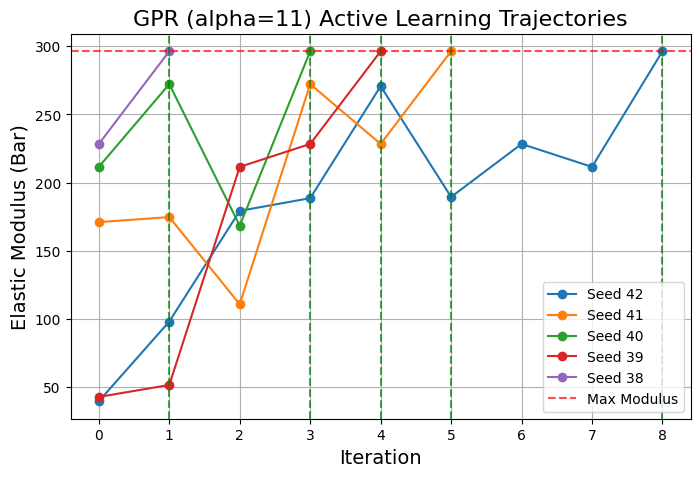

In [71]:
gpr11_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha11_seed42.csv")
gpr11_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha11_seed41.csv")
gpr11_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha11_seed40.csv")
gpr11_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha11_seed39.csv")
gpr11_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha11_seed38.csv")

plot_multiple_trajectories([gpr11_randomseed42, gpr11_randomseed41, gpr11_randomseed40, gpr11_randomseed39, gpr11_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=11)")

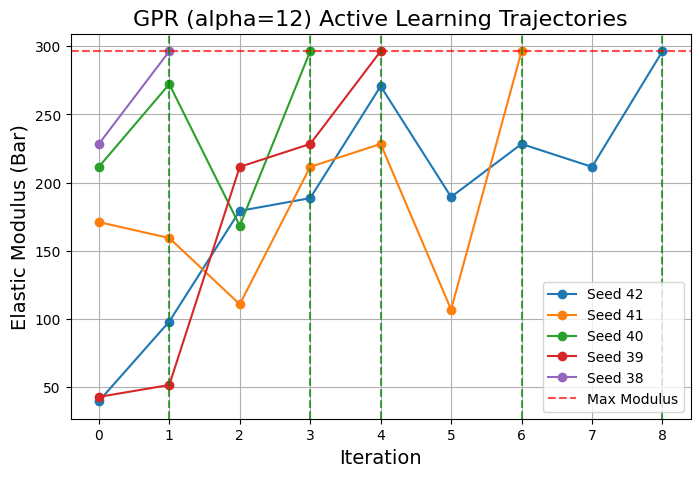

In [22]:
gpr12_randomseed42 = pd.read_csv("gpr_experiment_trajectory_alpha12_seed42.csv")
gpr12_randomseed41 = pd.read_csv("gpr_experiment_trajectory_alpha12_seed41.csv")
gpr12_randomseed40 = pd.read_csv("gpr_experiment_trajectory_alpha12_seed40.csv")
gpr12_randomseed39 = pd.read_csv("gpr_experiment_trajectory_alpha12_seed39.csv")
gpr12_randomseed38 = pd.read_csv("gpr_experiment_trajectory_alpha12_seed38.csv")

plot_multiple_trajectories([gpr12_randomseed42, gpr12_randomseed41, gpr12_randomseed40, gpr12_randomseed39, gpr12_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=12)")

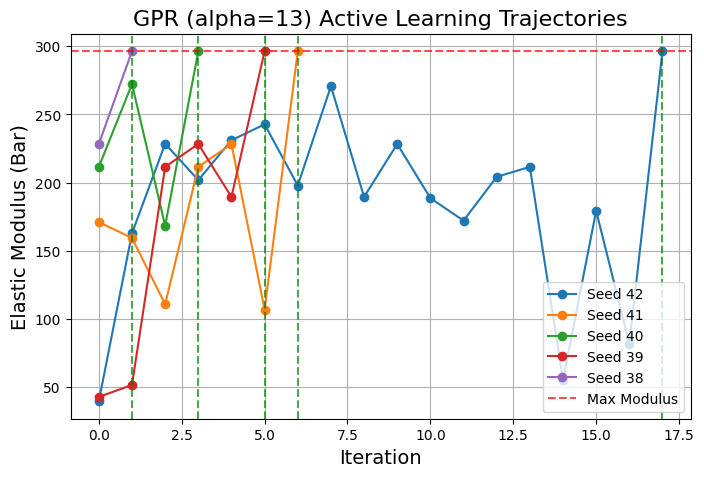

In [46]:
gpr13_randomseed42 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha13_seed42.csv")
gpr13_randomseed41 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha13_seed41.csv")
gpr13_randomseed40 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha13_seed40.csv")
gpr13_randomseed39 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha13_seed39.csv")
gpr13_randomseed38 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha13_seed38.csv")

plot_multiple_trajectories([gpr13_randomseed42, gpr13_randomseed41, gpr13_randomseed40, gpr13_randomseed39, gpr13_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=13)")

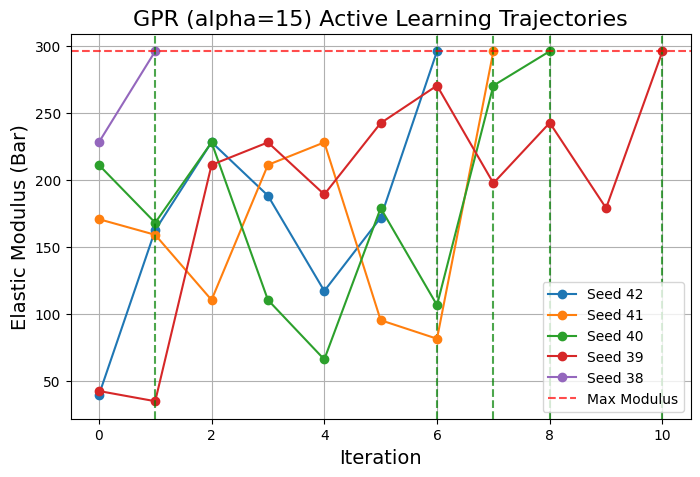

In [47]:
gpr15_randomseed42 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha15_seed42.csv")
gpr15_randomseed41 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha15_seed41.csv")
gpr15_randomseed40 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha15_seed40.csv")
gpr15_randomseed39 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha15_seed39.csv")
gpr15_randomseed38 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha15_seed38.csv")

plot_multiple_trajectories([gpr15_randomseed42, gpr15_randomseed41, gpr15_randomseed40, gpr15_randomseed39, gpr15_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=15)")

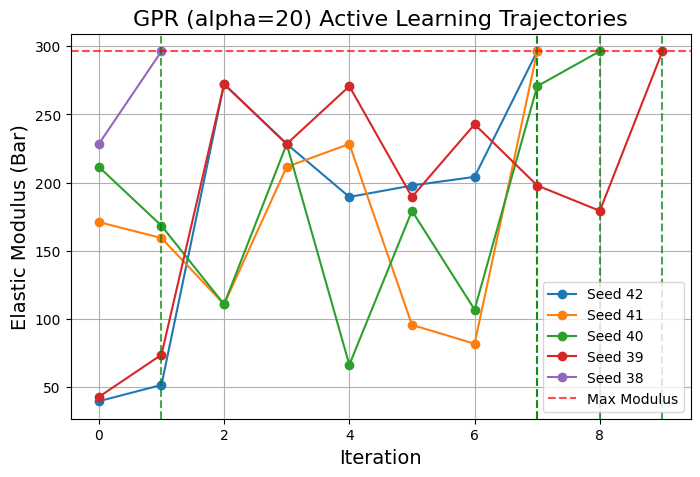

In [38]:
gpr20_randomseed42 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha20_seed42.csv")
gpr20_randomseed41 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha20_seed41.csv")
gpr20_randomseed40 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha20_seed40.csv")
gpr20_randomseed39 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha20_seed39.csv")
gpr20_randomseed38 = pd.read_csv("al_trajectory_data/gpr_experiment_trajectory_alpha20_seed38.csv")

plot_multiple_trajectories([gpr20_randomseed42, gpr20_randomseed41, gpr20_randomseed40, gpr20_randomseed39, gpr20_randomseed38], labels=["Seed 42", "Seed 41", "Seed 40", "Seed 39", "Seed 38"], title="GPR (alpha=20)")

C:\Users\wang9\AppData\Local\Temp\ipykernel_47720\2149723532.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y='Iteration_to_Max', data=results_df, order=label_order,
C:\Users\wang9\AppData\Local\Temp\ipykernel_47720\2149723532.py:61: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='Label', y='Iteration_to_Max', data=results_df, hue='Seed',


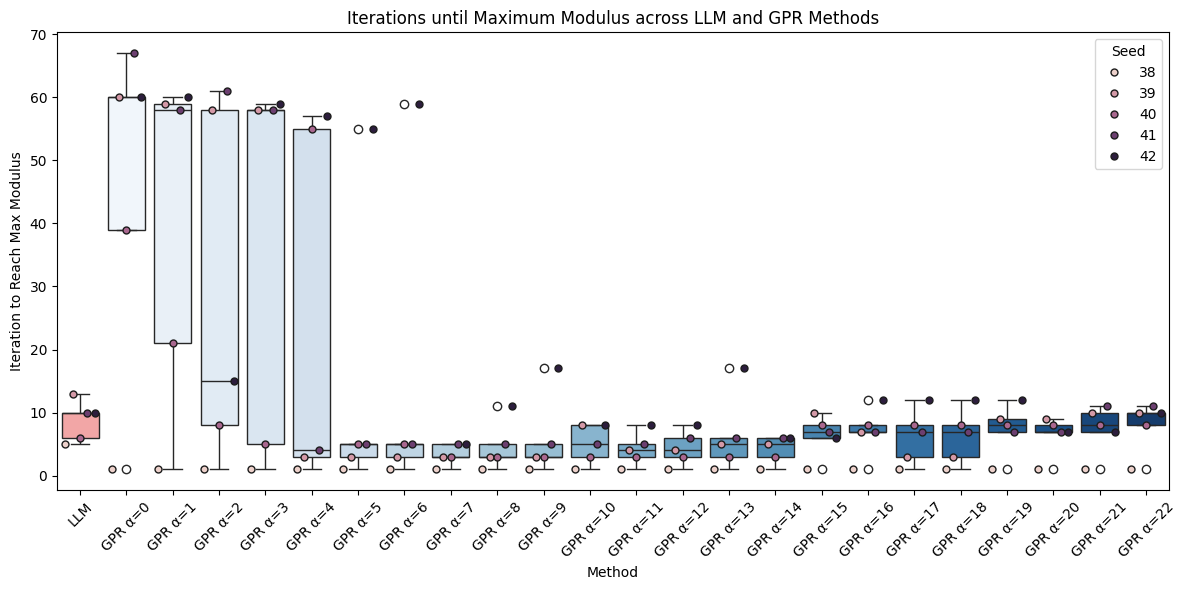

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re

# Define patterns to extract alpha and seed from filenames
pattern_gpr = re.compile(r"alpha(\d+)_seed(\d+)")
pattern_llm = re.compile(r"llm_experiment_trajectory_seed(\d+)")

# List all CSV files
csv_files_gpr = glob.glob("al_trajectory_data/gpr_experiment_trajectory_alpha*_seed*.csv")
csv_files_llm = glob.glob("al_trajectory_data/llm_experiment_trajectory_seed*.csv")

results = []

# Process GPR files
for file in csv_files_gpr:
    df = pd.read_csv(file)
    match = pattern_gpr.search(file)
    if match:
        alpha = int(match.group(1))
        seed = int(match.group(2))

        max_modulus = df['Max Modulus in Dataset'].iloc[0]

        reached_max = df[df['Observed Elastic Modulus'] >= max_modulus]
        iteration_to_max = reached_max['Iteration'].iloc[0] if not reached_max.empty else df['Iteration'].max()

        results.append({'Method': 'GPR', 'Alpha': alpha, 'Seed': seed, 'Iteration_to_Max': iteration_to_max})

# Process LLM files
for file in csv_files_llm:
    df = pd.read_csv(file)
    match = pattern_llm.search(file)
    if match:
        seed = int(match.group(1))

        max_modulus = df['Max Modulus in Dataset'].iloc[0]

        reached_max = df[df['Observed Elastic Modulus'] >= max_modulus]
        iteration_to_max = reached_max['Iteration'].iloc[0] if not reached_max.empty else df['Iteration'].max()

        results.append({'Method': 'LLM', 'Alpha': -1, 'Seed': seed, 'Iteration_to_Max': iteration_to_max})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plotting using boxplot
plt.figure(figsize=(12, 6))

# Create ordered list of alphas (LLM first as Alpha = -1)
alpha_order = sorted(results_df['Alpha'].unique())

# Relabel x-axis for plotting (LLM + GPR α=X)
results_df['Label'] = results_df.apply(lambda row: 'LLM' if row['Method'] == 'LLM' else f"GPR α={row['Alpha']}", axis=1)
label_order = ['LLM'] + [f"GPR α={a}" for a in alpha_order if a != -1]

sns.boxplot(x='Label', y='Iteration_to_Max', data=results_df, order=label_order,
            palette=['#ff9999'] + sns.color_palette("Blues", len(label_order) - 1))
sns.stripplot(x='Label', y='Iteration_to_Max', data=results_df, hue='Seed',
              dodge=True, jitter=True, linewidth=1, edgecolor='gray', order=label_order)

plt.xticks(rotation=45)
plt.xlabel("Method")
plt.ylabel("Iteration to Reach Max Modulus")
plt.title("Iterations until Maximum Modulus across LLM and GPR Methods")
plt.legend(title="Seed",  loc='upper right')
plt.tight_layout()

plt.show()

# Toy problem AL

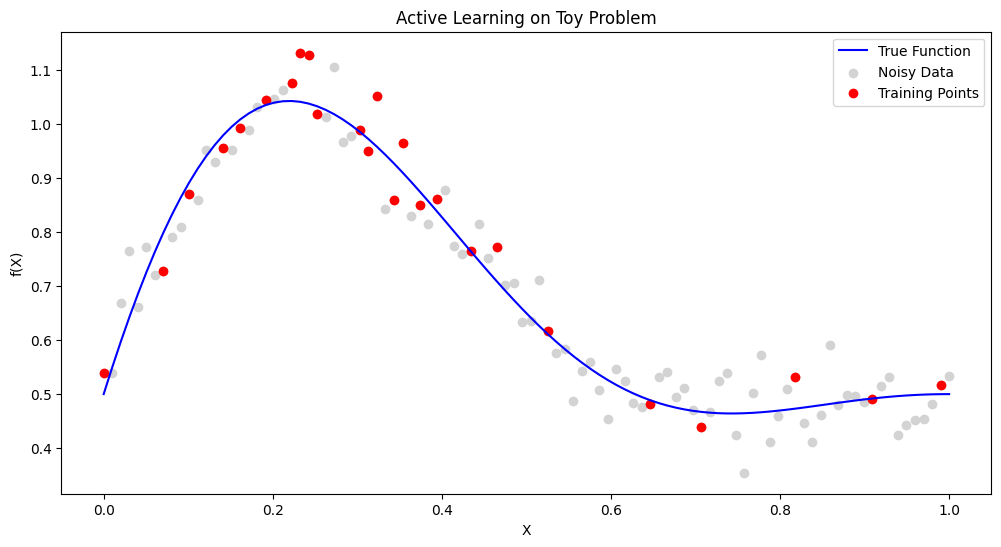

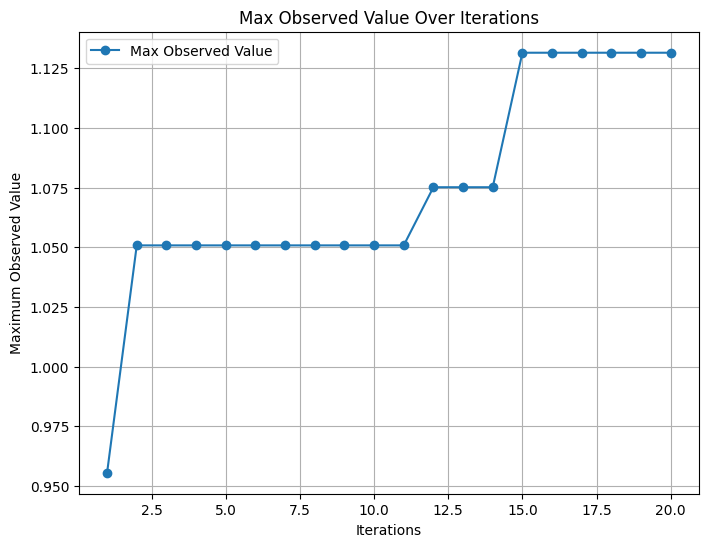

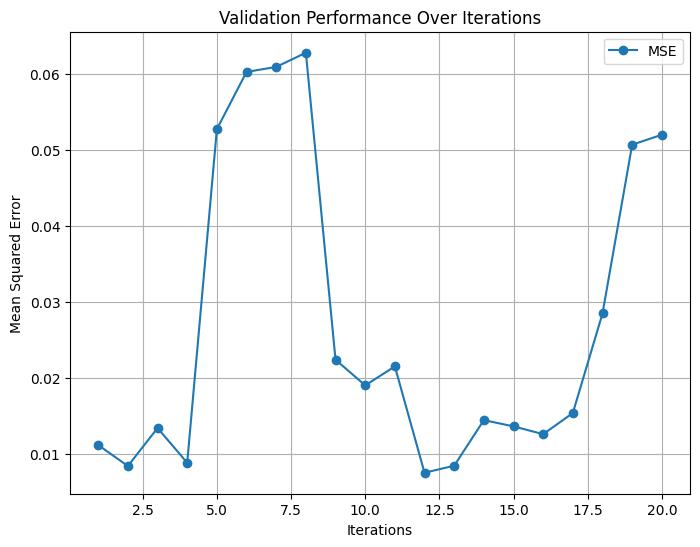

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Define the target function for the toy problem
def target_function(x):
    return np.sin(5 * x) * (1 - x) ** 2 + 0.5

# Generate toy dataset
def create_toy_data(n_samples=100, noise=0.05):
    X = np.linspace(0, 1, n_samples).reshape(-1, 1)  # Candidates in [0, 1]
    y = target_function(X.flatten()) + np.random.normal(0, noise, size=X.shape[0])
    return X, y

# Define the Active Learning UCB class
class ActiveLearningUCB:
    def __init__(self, kernel=None, alpha=1.0):
        self.alpha = alpha
        self.kernel = kernel if kernel else C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def ucb_acquisition(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        return mean + self.alpha * std, mean, std

    def select_next_point(self, X_candidates):
        ucb_scores, mean, std = self.ucb_acquisition(X_candidates)
        return np.argmax(ucb_scores), ucb_scores, mean, std

# Active learning loop
def run_active_learning_toy_problem(X, y, max_iterations=20, alpha_initial=3, alpha_decay=0.1, early_stopping_threshold=1e-4):
    # Normalize the data
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Initial training data
    n_initial = 5  # Number of initial training points
    initial_indices = np.random.choice(len(X), size=n_initial, replace=False)
    X_train = X[initial_indices]
    y_train = y[initial_indices]
    X_train_normalized = scaler.transform(X_train)

    # Initialize Active Learning Model
    al_model = ActiveLearningUCB(alpha=alpha_initial)
    al_model.update_model(X_train_normalized, y_train)

    # Tracking variables
    selected_indices = list(initial_indices)
    iteration_indices = []
    selected_modulus = []
    mse_per_iteration = []
    max_observed_value = []

    for iteration in range(max_iterations):
        # Dynamic alpha adjustment
        al_model.alpha = max(1, alpha_initial / (1 + iteration * alpha_decay))

        # Filter available candidates
        available_indices = [i for i in range(len(X)) if i not in selected_indices]
        X_candidates_filtered = X_normalized[available_indices]

        # Select next point
        selected_idx_local, ucb_scores, mean, std = al_model.select_next_point(X_candidates_filtered)
        selected_idx = available_indices[selected_idx_local]

        # Record information
        iteration_indices.append(iteration + 1)
        selected_indices.append(selected_idx)
        selected_modulus.append(y[selected_idx])
        max_observed_value.append(max(y_train))  # Track max observed modulus

        # Update training set
        X_new = X[[selected_idx]]
        y_new = y[[selected_idx]]
        X_new_normalized = scaler.transform(X_new)

        X_train = np.vstack([X_train, X_new])
        y_train = np.append(y_train, y_new)
        X_train_normalized = np.vstack([X_train_normalized, X_new_normalized])

        al_model.update_model(X_train_normalized, y_train)

        # Calculate MSE
        predictions = al_model.model.predict(X_normalized)
        mse = mean_squared_error(y, predictions)
        mse_per_iteration.append(mse)

        # Early stopping
        if len(mse_per_iteration) > 1 and abs(mse_per_iteration[-1] - mse_per_iteration[-2]) < early_stopping_threshold:
            print(f"Stopping early at iteration {iteration + 1} due to minimal improvement in MSE.")
            break

    # Final visualization
    plot_toy_problem_results(X, y, X_train, y_train, mean, std, iteration_indices, selected_modulus, mse_per_iteration, max_observed_value)

# Visualization
def plot_toy_problem_results(X, y, X_train, y_train, mean, std, iteration_indices, selected_modulus, mse_per_iteration, max_observed_value):
    # Ground truth function
    plt.figure(figsize=(12, 6))
    plt.plot(X, target_function(X.flatten()), label="True Function", color="blue")
    plt.scatter(X, y, label="Noisy Data", color="lightgray")
    plt.scatter(X_train, y_train, label="Training Points", color="red")
    #plt.fill_between(X.flatten(), mean - 1.96 * std, mean + 1.96 * std, alpha=0.3, label="GP Confidence Interval")
    plt.xlabel("X")
    plt.ylabel("f(X)")
    plt.legend()
    plt.title("Active Learning on Toy Problem")
    plt.show()

    # Modulus vs. Iterations
    plt.figure(figsize=(8, 6))
    plt.plot(iteration_indices, max_observed_value, marker="o", label="Max Observed Value")
    plt.xlabel("Iterations")
    plt.ylabel("Maximum Observed Value")
    plt.title("Max Observed Value Over Iterations")
    plt.legend()
    plt.grid()
    plt.show()

    # MSE vs. Iterations
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(mse_per_iteration) + 1), mse_per_iteration, marker="o", label="MSE")
    plt.xlabel("Iterations")
    plt.ylabel("Mean Squared Error")
    plt.title("Validation Performance Over Iterations")
    plt.legend()
    plt.grid()
    plt.show()

# Run the toy problem
X, y = create_toy_data()
run_active_learning_toy_problem(X, y)


# LLM - Cohere Reranking